In [1]:
from zipfile import ZipFile
import glob, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import fnmatch
import datetime as dt
from statistics import median
from matplotlib.ticker import PercentFormatter
from matplotlib import font_manager as fm
from matplotlib.gridspec import GridSpec
from matplotlib import ticker as ticker
from datetime import datetime, timedelta
import datetime
import dask.dataframe as dd

In [2]:
zip_files=glob.glob('Bases/*.zip')
extracted_files=glob.glob('*.csv')
#zip_files
num_files=len(zip_files)
#print(extracted_files)

DATOS DESCARGADOS DESDE https://www.gob.mx/salud/documentos/datos-abiertos-152127

# OBTENER INFORMACIÓN

In [3]:
file_name=zip_files[0]
file_name=file_name.split("Bases\\")[1].split(".zip",1)[0]
#file_name

## Extracción de archivos ZIP 

In [4]:
for f in range(num_files):
    #print(f)
    file=zip_files[f]
    with ZipFile (file,"r") as zf:
        
        ##GET FILE NAME
        file_name=zf.namelist()
        #print(file_name)
        
        ##SEARCH IF THE FILE WAS ALREADY EXTRACTED BEFORE
        if file_name[0] in extracted_files:
            next
            #print(str(file_name) + "already extracted")
        
        ##IF THE FILE WAS NOT EXTRACTED BEFORE, THEN EXTRACT AND NOTICE
        else:
            #print("added" + str(file_name))
            zf.extractall()
            extracted_files=glob.glob('*.csv')

## Carga de Bases de Datos

### Catálogos

In [5]:
Catalogos=pd.ExcelFile("diccionario_datos_covid19/Catalogos_0412.xlsx")
#Catalogos.sheet_names

## Decálogo 

In [6]:
descriptores=pd.read_excel("diccionario_datos_covid19/Descriptores_0419.xlsx")

In [7]:
#Elimina acentos en Descriptores[Formato o Fuente]
descriptores["FORMATO O FUENTE"]=descriptores["FORMATO O FUENTE"].str.replace("Á","A")
descriptores["FORMATO O FUENTE"]=descriptores["FORMATO O FUENTE"].str.replace("Ó","O")
descriptores["NOMBRE DE VARIABLE"]=descriptores["NOMBRE DE VARIABLE"].str.replace("OTRAS_COM","OTRA_COM")
#descriptores

In [8]:
#Determina tipos de columnas para reducir uso de memoria

dtypes={"ID_REGISTRO":"object","MUNICIPIO_RES":"object","PAIS_NACIONALIDAD":"object","PAIS_ORIGEN":"object",
       "INTUBADO":"uint8","NEUMONIA":"uint8","EMBARAZO":"uint8","HABLA_LENGUA_INDIG":"uint8","DIABETES":"uint8",
        "EPOC":"uint8","ASMA":"uint8","INMUSUPR":"uint8","HIPERTENSION":"uint8","OTRA_COM":"uint8","UCI":"uint8",
        "CARDIOVASCULAR":"uint8","OBESIDAD":"uint8","RENAL_CRONICA":"uint8","TABAQUISMO":"uint8","OTRO_CASO":"uint8",
        "TIPO_PACIENTE":"uint8","ORIGEN":"uint8","SECTOR":"uint8","ENTIDAD_UM":"uint8","SEXO":"uint8",
        "ENTIDAD_NAC":"uint8","ENTIDAD_RES":"uint8","MIGRANTE":"uint8","NACIONALIDAD":"uint8","EDAD":"uint8",
        "RESULTADO":"uint8","NACIONALIDAD":"uint8"}

col_fechas=["FECHA_ACTUALIZACION"]

### Bases de Datos: Casos COVID

In [9]:
for f in range(len(extracted_files)):
    if f == 0:
        current_file_name=extracted_files[f]
        
        #total_dbs=pd.read_csv(current_file_name,dtype=dtypes)
        ddbs=dd.read_csv(current_file_name,dtype=dtypes)
        
        fecha_real="20"+current_file_name[0:2]+"-"+current_file_name[2:4]+"-"+current_file_name[4:6]
        
        #Sustituye la Fecha_Actualizacion con la Fecha en el nombre del archivo
        #total_dbs["FECHA_ACTUALIZACION"]=fecha_real
        ddbs=ddbs.assign(FECHA_ACTUALIZACION=fecha_real)
        
    else:
        current_file_name=extracted_files[f]
        
        #current_file=pd.read_csv(current_file_name,encoding='latin-1',dtype=dtypes,parse_dates=col_fechas)
        current_file=dd.read_csv(current_file_name, parse_dates=["FECHA_ACTUALIZACION"],dtype=dtypes,encoding="latin-1")       
        
        fecha_real="20"+current_file_name[0:2]+"-"+current_file_name[2:4]+"-"+current_file_name[4:6]
        
        #Sustituye la Fecha_Actualizacion con la Fecha en el nombre del archivo
        current_file=current_file.assign(FECHA_ACTUALIZACION=fecha_real)
        #current_file["FECHA_ACTUALIZACION"]=fecha_real
        
        ddbs=ddbs.append(current_file)
        #print(current_file_name)

total_dbs=ddbs.compute()
del ddbs

In [10]:
#total_dbs.tail()

In [11]:
#Comprobación de bases cargads
reportes=total_dbs.FECHA_ACTUALIZACION.unique()
#reportes

## Descripción de claves: Variables que cambian en el tiempo 

In [12]:
total_dbs_columns=list(total_dbs.columns)

origen=[]
sector=[]
sexo=[]
tipo_paciente=[]
si_no=[]
nacionalidad=[]
resultado=[]
entidades=[]
municipios=[]

In [13]:
#Selección de catálogo a utilizar por columna
total_dbs_columns=list(total_dbs.columns)

for c in range (len(total_dbs_columns)):
    #print(c)
    #print(total_dbs_columns[c])
    
    #Determina información en Columna Formato Fuente
    rFoF=descriptores.loc[descriptores["NOMBRE DE VARIABLE"]==total_dbs_columns[c],["FORMATO O FUENTE"]]
    #print(rFoF)
    FoF=rFoF["FORMATO O FUENTE"][c]
    
    #Si la información contiene Catalogo, entonces hace búsqueda del catálogo para traducir la información
    if "CATALOGO" in FoF:
        cat = rFoF["FORMATO O FUENTE"][c].split(": ",1)[1]
        cat=str(cat.replace(" ",""))
        #print(cat)
        
        if cat == "ORIGEN":
            origen.append(total_dbs_columns[c])
            #print(ORIGEN)
            
        elif cat == "SECTOR":
            sector.append(total_dbs_columns[c])
            #print(SECTOR)
            
        elif cat =="SEXO":
            sexo.append(total_dbs_columns[c])
            #print(SEXO)
        
        elif cat =="TIPO_PACIENTE":
            tipo_paciente.append(total_dbs_columns[c])
            #print(TIPO_PACIENTE)
            
        elif cat =="SI_NO":
            si_no.append(total_dbs_columns[c])
            #print(SI_NO)
        
        elif cat=="NACIONALIDAD":
            nacionalidad.append(total_dbs_columns[c])
            #print(NACIONALIDAD)
        
        elif cat=="RESULTADO":
            resultado.append(total_dbs_columns[c])
            #print(RESULTADO)
            
        elif cat=="ENTIDADES":
            entidades.append(total_dbs_columns[c])
            #print(ENTIDADES)
        
        elif cat=="MUNICIPIOS":
            municipios.append(total_dbs_columns[c])
            #print(MUNICIPIOS)

In [14]:
catalogos_variables=[tipo_paciente,si_no,resultado]
nombre_catalogos_variables=["TIPO_PACIENTE","SI_NO","RESULTADO"]

In [15]:
#total_dbs.columns

In [16]:
catalogos_fijos=[origen,sector,sexo,nacionalidad,entidades,municipios]
nombre_catalogos_fijos=["ORIGEN","SECTOR","SEXO","NACIONALIDAD","ENTIDADES","MUNICIPIOS"]

identificacion=['ORIGEN', 'SECTOR', 'ENTIDAD_UM','SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES','EDAD',
                'NACIONALIDAD', 'HABLA_LENGUA_INDIG','MIGRANTE', 'PAIS_NACIONALIDAD','PAIS_ORIGEN']
comorbilidades=['EMBARAZO','DIABETES','EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM','CARDIOVASCULAR', 'OBESIDAD',
                'RENAL_CRONICA', 'TABAQUISMO']

### Columnas para identificación del individuo

ORIGEN, SECTOR, ENTIDAD_UM, SEXO, ENTIDAD_NAC, ENTIDAD_RES, MUNICIPIO_RES, EDAD, NACIONALIDAD, HABLA_LENGUA_INDIG, MIGRANTE, PAIS_NACIONALIDAD, PAIS_ORIGEN

In [17]:
db_tiempo=total_dbs.drop(columns=['ORIGEN', 'SECTOR', 'ENTIDAD_UM','SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES',
                                  'EDAD','NACIONALIDAD', 'HABLA_LENGUA_INDIG','MIGRANTE', 'PAIS_NACIONALIDAD','PAIS_ORIGEN',
                        'EMBARAZO','DIABETES','EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM','CARDIOVASCULAR',
                        'OBESIDAD','RENAL_CRONICA', 'TABAQUISMO','OTRO_CASO'])
db_tiempo.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,RESULTADO,UCI
0,2020-04-12,09e8dc,2,2020-04-09,2020-03-28,9999-99-99,2,1,1,1
1,2020-04-12,0efbaf,1,2020-04-06,2020-04-04,9999-99-99,97,2,1,97
2,2020-04-12,091a48,2,2020-04-06,2020-04-04,9999-99-99,2,1,2,2
3,2020-04-12,13236c,2,2020-04-02,2020-03-26,9999-99-99,2,1,2,2
4,2020-04-12,0cdb12,2,2020-03-28,2020-03-17,9999-99-99,2,1,1,2


In [18]:
for col in range(len(si_no)):
    #print(si_no[col])
    try:
        db_tiempo[si_no[col]]=db_tiempo[si_no[col]].str.strip()
    except:
        print("Not Found: " + si_no[col])

Not Found: INTUBADO
Not Found: NEUMONIA
Not Found: EMBARAZO
Not Found: HABLA_LENGUA_INDIG
Not Found: DIABETES
Not Found: EPOC
Not Found: ASMA
Not Found: INMUSUPR
Not Found: HIPERTENSION
Not Found: OTRA_COM
Not Found: CARDIOVASCULAR
Not Found: OBESIDAD
Not Found: RENAL_CRONICA
Not Found: TABAQUISMO
Not Found: OTRO_CASO
Not Found: MIGRANTE
Not Found: UCI


In [19]:
#Descripción de códigos variables en el tiempo
for cv in range(len(catalogos_variables)):
    sheet="Catálogo "+ str(nombre_catalogos_variables[cv])
    catalogo = catalogos_variables[cv]
    
    dbcat=pd.read_excel("diccionario_datos_covid19/Catalogos_0412.xlsx",sheet_name=sheet)

    try:
        #print("try" + str(sheet))
        keys=dbcat["CLAVE"].tolist()
    
    except:
        dbcat=pd.read_excel("diccionario_datos_covid19/Catalogos_0412.xlsx",sheet_name=sheet,skiprows=1)
        keys=dbcat["CLAVE"].tolist()
        
    values=dbcat["DESCRIPCIÓN"].tolist()
    dictionary = dict(zip(keys, values))

    try:
        for col in range(len(catalogo)):
            db_tiempo[catalogo[col]]=db_tiempo[catalogo[col]].map(dictionary)
            db_tiempo.loc[:,catalogo]=db_tiempo[catalogo].astype("category")
            #print(total_dbs[catalogo[col]].unique())
            
    except:
        pass
                
    #Categorizar las columnas, menor consumo de memoria 
    #valores_unicos=len(total_dbs[str(catalogo[0])].unique())
    #total_valores=total_dbs[str(catalogo[0])].count()
    #if valores_unicos/total_valores<0.5:
    #    total_dbs.loc[:,catalogo]=total_dbs[catalogo].astype("category")
    #else:
    #    total_dbs.loc[:,catalogo]=total_dbs[catalogo]

In [20]:
db_tiempo.dtypes

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
TIPO_PACIENTE          category
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                 object
NEUMONIA                  uint8
RESULTADO              category
UCI                       uint8
dtype: object

In [21]:
db_tiempo["FECHA_ACTUALIZACION"]=pd.to_datetime(db_tiempo["FECHA_ACTUALIZACION"].str.strip(), format="%Y-%m-%d")
db_tiempo["FECHA_SINTOMAS"]=pd.to_datetime(db_tiempo["FECHA_SINTOMAS"].str.strip(), format="%Y-%m-%d")
db_tiempo["FECHA_DEF"]=pd.to_datetime(db_tiempo["FECHA_DEF"].str.strip(), format="%Y-%m-%d", errors="coerce")
#total_dbs["FECHA_ACTUALIZACION"].unique()

In [22]:
fecha_primer_reporte=min(reportes)
fecha_ultimo_reporte=max(reportes)
susana_distancia=datetime.datetime(2020, 3, 23)
nueva_normalidad=datetime.datetime(2020, 6, 1)

In [23]:
#total_dbs.columns
datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')
fecha_ultimo_reporte

'2020-09-12'

# EVOLUCIÓN EN EL TIEMPO

R1 = Primer Reporte en el cual aparece el ID

R2 = Primer Reporte en el cual se tiene un resultado (positivo o negativo)

R3 = Primer Reporte en el cual se registra fecha de defunción

RX = Último Reporte generado

Rt = Consolidado de reportes (R1, R2, R3, RX) con base en el último reporte

## Información de los casos reportados en el último reporte (Rx)

Identificación de casos: ID_REGISTRO, FECHA_SINTOMAS

In [24]:
#Obtener estado actual del caso
Rx = db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","FECHA_SINTOMAS","RESULTADO",
               "TIPO_PACIENTE","INTUBADO","UCI","FECHA_DEF"]]

#Obtener registros con Fecha de Actualización del último reporte
Rx = Rx.loc[Rx["FECHA_ACTUALIZACION"]==fecha_ultimo_reporte]



#Renombrar columnas para identificar la información obtenida del último reporte
Rx = Rx.rename(columns={"RESULTADO":"RX_RESULTADO","TIPO_PACIENTE":"RX_TIPO_PACIENTE",
                        "INTUBADO":"RX_INTUBADO","UCI":"RX_UCI","FECHA_ACTUALIZACION":"RX_FECHA"})

Rx.head()

,ID_REGISTRO,RX_FECHA,FECHA_SINTOMAS,RX_RESULTADO,RX_TIPO_PACIENTE,RX_INTUBADO,RX_UCI,FECHA_DEF
0,114cd3,2020-09-12,2020-06-29,Positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT
1,0bafd8,2020-09-12,2020-04-28,Positivo SARS-CoV-2,HOSPITALIZADO,SI,2,2020-05-09
2,18747a,2020-09-12,2020-04-10,Positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT
3,174174,2020-09-12,2020-04-11,Positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT
4,0eae86,2020-09-12,2020-04-21,Positivo SARS-CoV-2,HOSPITALIZADO,SI,1,NaT


In [25]:
#Último reporte como base para reporte consolidado
Rt=Rx
total_registros=Rt.shape[0]
total_positivos=Rt.loc[Rt["RX_RESULTADO"]=="Positivo SARS-CoV-2"].shape[0]
total_negativos=Rt.loc[Rt["RX_RESULTADO"]=="No positivo SARS-CoV-2"].shape[0]
total_pendientes=Rt.loc[Rt["RX_RESULTADO"]=="Resultado pendiente"].shape[0]
total_defunciones=Rt.loc[(Rt["RX_RESULTADO"]=="Positivo SARS-CoV-2") & (Rt["FECHA_DEF"].notnull())].shape[0]

total_registros='{:,}'.format(total_registros)
total_positivos='{:,}'.format(total_positivos)
total_negativos='{:,}'.format(total_negativos)
total_pendientes='{:,}'.format(total_pendientes)
total_defunciones='{:,}'.format(total_defunciones)

In [26]:
#Comprobación 1
print("Total Registros: " + str(total_registros))
print("Total Positivos: " + str(total_positivos))
print("Total Negativos: "+ str(total_negativos))
print("Total Pendientes: " + str(total_pendientes))
print("Total Defunciones COVID: " + str(total_defunciones))

Total Registros: 1,510,311
Total Positivos: 663,973
Total Negativos: 759,188
Total Pendientes: 87,150
Total Defunciones COVID: 70,604


## Información del primer reporte (R1)
Obtener información del reporte donde se registra por primera vez cada ID que existe en el últimpo reporte.

In [27]:
#Obtener información de identificación de cada caso
R1 = db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","FECHA_SINTOMAS"]]

#Obtener primera fecha en la cual aparece cada ID
R1 = R1.groupby(["ID_REGISTRO","FECHA_SINTOMAS"], as_index=False).min()

R1 = R1.rename(columns={"FECHA_ACTUALIZACION":"R1_FECHA"})

#Primer Resultado registrado y Tipo paciente
aux_R1=db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","RESULTADO","TIPO_PACIENTE"]]

R1 = R1.merge(aux_R1,left_on=["ID_REGISTRO","R1_FECHA"],
              right_on=["ID_REGISTRO","FECHA_ACTUALIZACION"],how="left")

R1=R1.rename(columns={"RESULTADO":"R1_RESULTADO","TIPO_PACIENTE":"R1_TIPO_PACIENTE"})

R1=R1.loc[:,["ID_REGISTRO","R1_FECHA","R1_RESULTADO","R1_TIPO_PACIENTE","FECHA_SINTOMAS"]]

#Días transcurridos entre que el paciente declara sentir síntomas y el registro del caso (T1)
R1["T1"]=(R1["R1_FECHA"]-R1["FECHA_SINTOMAS"]).dt.days

#Rango de días entre que el paciente declara sentir síntomas y el registro del caso
t1_rango=[min(R1["T1"]),4,9,14,max(R1["T1"])]
t1_etiqueta=("0 - 4", "5 - 9","10 - 14", "15+")

R1["T1_RANGO"]=pd.cut(R1["T1"],t1_rango,labels=t1_etiqueta)

R1=R1.sort_values(by="R1_FECHA")

In [28]:
#Obtener resultados registrados en el primer reporte

primer_reporte=R1.loc[R1["R1_FECHA"] ==fecha_primer_reporte]
registros_primer_reporte=primer_reporte["ID_REGISTRO"].count()
#registros_primer_reporte='{:,}'.format(registros_primer_reporte)

covid_primer_reporte=(primer_reporte.loc[primer_reporte["R1_RESULTADO"]=="Positivo SARS-CoV-2","ID_REGISTRO"]).count()
#covid_primer_reporte='{:,}'.format(covid_primer_reporte)

nocovid_primer_reporte=primer_reporte.loc[primer_reporte["R1_RESULTADO"]=="No positivo SARS-CoV-2","ID_REGISTRO"].count()
#nocovid_primer_reporte='{:,}'.format(nocovid_primer_reporte)

pendientes_primer_reporte=primer_reporte.loc[primer_reporte["R1_RESULTADO"]=="Resultado pendiente","ID_REGISTRO"].count()
#pendientes_primer_reporte='{:,}'.format(pendientes_primer_reporte)

print("Registros primer reporte: "+str(registros_primer_reporte))
print("Registros positivos primer reporte: "+str(covid_primer_reporte))
print("Registros negativos reporte: "+str(nocovid_primer_reporte))
print("Registros pendientes reporte: "+str(pendientes_primer_reporte))

Registros primer reporte: 36594
Registros positivos primer reporte: 4661
Registros negativos reporte: 23236
Registros pendientes reporte: 8697


In [29]:
#Agregar la información del primer reporte (R1) al consolidado de bases (Rt)
Rt=Rt.merge(R1,on=["ID_REGISTRO","FECHA_SINTOMAS"],how="left")

In [30]:
#Comprobación 2
Rt.groupby(["RX_RESULTADO"], as_index=False)["ID_REGISTRO","FECHA_DEF"].count()

,RX_RESULTADO,ID_REGISTRO,FECHA_DEF
0,No positivo SARS-CoV-2,759188,17434
1,Positivo SARS-CoV-2,663973,70604
2,Resultado pendiente,87150,2157


### Positividad por días entre síntomas y registro (Justificación rangos seleccionados)
A partir del día 5 desde el comienzo de los síntomas, el porcentaje de casos positivos es mayor al de los negativos. A partir de esto, se asumen rangos de 5 días (0 a 4 días, 5 a 9 días, 10 a 14 días, 15 días o más).

Se ha reportado que la enfermedad dura en promedio 14 días, por esto el último rango es de 15 días o más.

In [31]:
base_T1_rango=Rt.loc[:,["T1","RX_RESULTADO","ID_REGISTRO"]]
base_T1_rango=base_T1_rango.groupby(["T1","RX_RESULTADO"],as_index=False).count()

aux_T1_rango_covid=base_T1_rango.loc[base_T1_rango["RX_RESULTADO"]=="Positivo SARS-CoV-2"]
aux_T1_rango_covid=aux_T1_rango_covid.rename(columns={"ID_REGISTRO":"COVID"})

aux_T1_rango_nocovid=base_T1_rango.loc[base_T1_rango["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
aux_T1_rango_nocovid=aux_T1_rango_nocovid.rename(columns={"ID_REGISTRO":"NO_COVID"})

T1_rango=aux_T1_rango_covid.merge(aux_T1_rango_nocovid,on=["T1"],how="outer")
T1_rango=T1_rango.loc[:,["T1","COVID","NO_COVID"]]
T1_rango["POSITIVIDAD"]=T1_rango["COVID"]/(T1_rango["COVID"]+T1_rango["NO_COVID"])
#T1_rango.head(10)


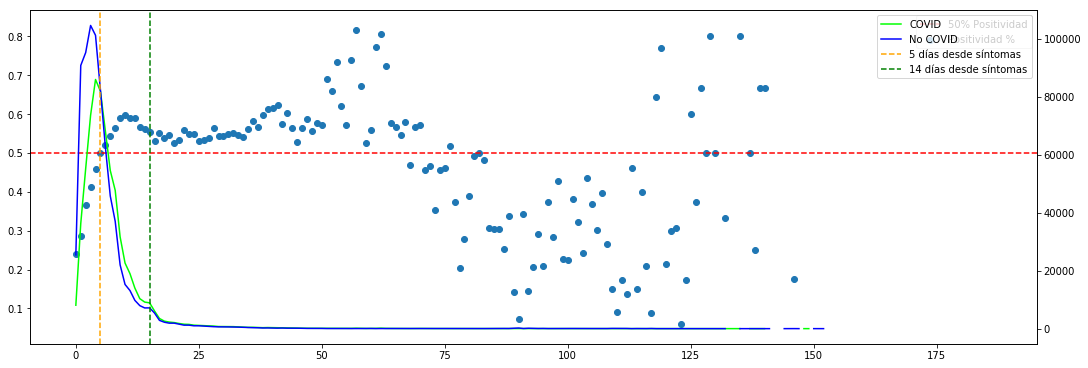

In [32]:
#Gráfica Positividad por días transcurridos entre síntomas y registro

fig = plt.figure(constrained_layout=True,figsize=[15,5])
plt.scatter(T1_rango["T1"],T1_rango["POSITIVIDAD"], label="Positividad %")
plt.axhline(y=.5,color="red",linestyle="--",label="50% Positividad")
plt.legend()

plt.twinx()
plt.plot(T1_rango["T1"],T1_rango["COVID"], label="COVID",color="lime")
plt.plot(T1_rango["T1"],T1_rango["NO_COVID"], label="No COVID", color="blue")


plt.axvline(x=5,color="orange",linestyle="--", label="5 días desde síntomas")
plt.axvline(x=15,color="green",linestyle="--", label="14 días desde síntomas")

plt.legend()


## Información del primer reporte con resultado (R2)

In [33]:
#Primer reporte en el cual aparece el ID con resultado de prueba (Positivo o No Positivo)

R2 = db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","RESULTADO","FECHA_SINTOMAS"]]
R2 = R2.loc[R2["RESULTADO"]!="Resultado pendiente",:]
R2 = R2.groupby(["ID_REGISTRO","FECHA_SINTOMAS"],as_index=False).min()
R2 = R2.rename(columns={"FECHA_ACTUALIZACION":"R2_FECHA"})

#Tipo paciente y resultado cuando se obtuvo el resultado de la prueba
aux_R2 = db_tiempo.loc[:,["ID_REGISTRO","TIPO_PACIENTE","RESULTADO","FECHA_ACTUALIZACION","FECHA_SINTOMAS"]]

R2=R2.merge(aux_R2,left_on=["ID_REGISTRO","R2_FECHA","FECHA_SINTOMAS"],
            right_on=["ID_REGISTRO","FECHA_ACTUALIZACION","FECHA_SINTOMAS"])

R2=R2.loc[:,["ID_REGISTRO","R2_FECHA","TIPO_PACIENTE","RESULTADO","FECHA_SINTOMAS"]]
R2 = R2.rename(columns={"TIPO_PACIENTE":"R2_TIPO_PACIENTE","RESULTADO":"R2_RESULTADO"})

R2.head()

,ID_REGISTRO,R2_FECHA,R2_TIPO_PACIENTE,R2_RESULTADO,FECHA_SINTOMAS
0,000001,2020-08-05,AMBULATORIO,No positivo SARS-CoV-2,2020-08-01
1,000002,2020-07-03,AMBULATORIO,Positivo SARS-CoV-2,2020-06-25
2,000003,2020-08-23,AMBULATORIO,Positivo SARS-CoV-2,2020-08-18
3,000004,2020-07-21,AMBULATORIO,No positivo SARS-CoV-2,2020-07-12
4,000005,2020-07-24,AMBULATORIO,No positivo SARS-CoV-2,2020-07-18


In [34]:
#Agregar la información del primer reporte con resultado (R2) al consolidado de bases (Rt)
Rt=Rt.merge(R2,on=["ID_REGISTRO","FECHA_SINTOMAS"],how="left")

In [35]:
#Determinar los días transcurridos entre que se registró el caso (se asume se hizo la examen de COVID) y se obtuvo
#un resultado (Positivo o Negativo a SARS-CoV-2)

Rt["T2"]=(Rt["R2_FECHA"]-Rt["R1_FECHA"]).dt.days

t2_rango=[-1,3,7,14,max(Rt["T2"])]
t2_etiqueta=("0 - 3", "4 - 7","8 - 14", "15+")

Rt["T2_RANGO"]=pd.cut(Rt["T2"],t2_rango,labels=t2_etiqueta)

Rt.head()

,ID_REGISTRO,RX_FECHA,FECHA_SINTOMAS,RX_RESULTADO,RX_TIPO_PACIENTE,RX_INTUBADO,RX_UCI,FECHA_DEF,R1_FECHA,R1_RESULTADO,R1_TIPO_PACIENTE,T1,T1_RANGO,R2_FECHA,R2_TIPO_PACIENTE,R2_RESULTADO,T2,T2_RANGO
0,114cd3,2020-09-12,2020-06-29,Positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-07-06,Resultado pendiente,AMBULATORIO,7,5 - 9,2020-07-08,AMBULATORIO,Positivo SARS-CoV-2,2.0,0 - 3
1,0bafd8,2020-09-12,2020-04-28,Positivo SARS-CoV-2,HOSPITALIZADO,SI,2,2020-05-09,2020-04-29,Resultado pendiente,HOSPITALIZADO,1,0 - 4,2020-05-01,HOSPITALIZADO,Positivo SARS-CoV-2,2.0,0 - 3
2,18747a,2020-09-12,2020-04-10,Positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-04-15,Resultado pendiente,AMBULATORIO,5,5 - 9,2020-04-20,AMBULATORIO,Positivo SARS-CoV-2,5.0,4 - 7
3,174174,2020-09-12,2020-04-11,Positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-04-23,Positivo SARS-CoV-2,AMBULATORIO,12,10 - 14,2020-04-23,AMBULATORIO,Positivo SARS-CoV-2,0.0,0 - 3
4,0eae86,2020-09-12,2020-04-21,Positivo SARS-CoV-2,HOSPITALIZADO,SI,1,NaT,2020-04-27,Positivo SARS-CoV-2,HOSPITALIZADO,6,5 - 9,2020-04-27,HOSPITALIZADO,Positivo SARS-CoV-2,0.0,0 - 3


In [36]:
#Comprobación 3
Rt.groupby(["RX_RESULTADO","R2_RESULTADO"],as_index=False)["ID_REGISTRO","FECHA_DEF"].count()

,RX_RESULTADO,R2_RESULTADO,ID_REGISTRO,FECHA_DEF
0,No positivo SARS-CoV-2,No positivo SARS-CoV-2,757376.0,17354.0
1,No positivo SARS-CoV-2,Positivo SARS-CoV-2,1812.0,80.0
2,No positivo SARS-CoV-2,Resultado pendiente,NaN,NaN
3,Positivo SARS-CoV-2,No positivo SARS-CoV-2,3361.0,456.0
4,Positivo SARS-CoV-2,Positivo SARS-CoV-2,660612.0,70148.0
5,Positivo SARS-CoV-2,Resultado pendiente,NaN,NaN
6,Resultado pendiente,No positivo SARS-CoV-2,88.0,14.0
7,Resultado pendiente,Positivo SARS-CoV-2,86.0,7.0
8,Resultado pendiente,Resultado pendiente,NaN,NaN


## Información de Defunciones (R3)

In [37]:
#R3 Primer Reporte en el cual se registra fecha de defunción

R3=db_tiempo.loc[total_dbs["FECHA_DEF"]!="9999-99-99"]
R3=R3.loc[:,["FECHA_ACTUALIZACION","ID_REGISTRO","FECHA_DEF","FECHA_SINTOMAS"]]
R3=R3.groupby(["ID_REGISTRO","FECHA_DEF","FECHA_SINTOMAS"],as_index=False).min()

aux_R3=db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","RESULTADO","TIPO_PACIENTE","FECHA_SINTOMAS"]]

R3 = R3.merge(aux_R3,on=["ID_REGISTRO","FECHA_SINTOMAS","FECHA_ACTUALIZACION"],how="left")

R3=R3.rename(columns={"RESULTADO":"R3_RESULTADO","TIPO_PACIENTE":"R3_TIPO_PACIENTE", "FECHA_ACTUALIZACION":"R3_FECHA"})

R3=R3.loc[:,["ID_REGISTRO","R3_FECHA","R3_RESULTADO","R3_TIPO_PACIENTE","FECHA_SINTOMAS"]]

R3.count()

ID_REGISTRO         92146
R3_FECHA            92146
R3_RESULTADO        92146
R3_TIPO_PACIENTE    92146
FECHA_SINTOMAS      92146
dtype: int64

In [38]:
#Agregar la información del primer reporte con resultado (R3) al consolidado de bases (Rt)
Rt=Rt.merge(R3,on=["ID_REGISTRO","FECHA_SINTOMAS"],how="left")

In [39]:
#Determinar los días transcurridos entre la fecha de defunción y el primer reporte donde se especifica FECHA_DEF
Rt["T3"]=(Rt["R3_FECHA"]-Rt["FECHA_DEF"]).dt.days

t3_rango=[0,7,14,21,np.nanmax(Rt["T3"])]
t3_etiquetas=("1 semana", "2 semana","3 semanas", "+3 semanas")

Rt["T3_RANGO"]=pd.cut(Rt["T3"],t3_rango,labels=t3_etiquetas)

#Determinar los días transcurridos entre la Fecha de Defunción y la fecha de registro del caso
Rt["T4"] = (Rt["FECHA_DEF"]-Rt["R1_FECHA"]).dt.days 

t4_rango=[np.nanmin(Rt["T3"]),1,7,14,21,np.nanmax(Rt["T3"])]
t4_etiquetas=("Def antes de registro","1 semana", "2 semana","3 semanas", "+3 semanas")
Rt["T4_RANGO"]=pd.cut(Rt["T4"],t4_rango,labels=t4_etiquetas)

#Determinar los días transcurridos entre la fecha de Defunción y la fecha de Sítomas
Rt["T5"]=(Rt["FECHA_DEF"]-Rt["FECHA_SINTOMAS"]).dt.days
t5_rango=[0,3,7,14,21,30,np.nanmax(Rt["T5"])]
t5_etiquetas=("3 días","1 semana","2 semanas","3 semanas","1 mes","+1 mes")

Rt["T5_RANGO"]=pd.cut(Rt["T5"],t5_rango,labels=t5_etiquetas)

In [40]:
#Comprobación 3
Rt.groupby(["RX_RESULTADO"],as_index=False)["ID_REGISTRO","FECHA_DEF"].count()

,RX_RESULTADO,ID_REGISTRO,FECHA_DEF
0,No positivo SARS-CoV-2,759215,17461
1,Positivo SARS-CoV-2,664106,70737
2,Resultado pendiente,87152,2159


# GRÁFICAS

## Sospechosos 

Información de todos los casos sospechosos reportados, con o sin resultado en el primer reporte

### Contabilizar casos por fecha

1. Cuántos casos se registraron cada día

In [41]:
#Filtrar información del primer registro (R1) de cada ID
db_registros=Rt.loc[:,["ID_REGISTRO","R1_FECHA"]]
R1_registros=db_registros.groupby(["R1_FECHA"],as_index=False).count()

R1_registros=R1_registros.rename(columns={"ID_REGISTRO":"NUM_REGISTROS"})

2. Cuántos casos reportaron haber iniciado con síntomas cada día

In [42]:
#Filtrar información del fecha síntomas de cada ID
db_sintomas=Rt.loc[:,["ID_REGISTRO","FECHA_SINTOMAS"]]
sintomas=db_sintomas.groupby(["FECHA_SINTOMAS"],as_index=False).count()

sintomas=sintomas.rename(columns={"ID_REGISTRO":"NUM_SINTOMAS"})

#sintomas.head()

Agrupar tabla por fecha de registro y por fecha de síntomas

In [43]:
sospechosos=sintomas.merge(R1_registros,left_on=["FECHA_SINTOMAS"],right_on=["R1_FECHA"],how="outer")
sospechosos=sospechosos.loc[:,["FECHA_SINTOMAS","R1_FECHA","NUM_SINTOMAS","NUM_REGISTROS"]]

#Establecer fecha única (eliminar columnas de Fecha Síntomas y Fecha Registro)
sospechosos["FECHA"]=sospechosos[["FECHA_SINTOMAS","R1_FECHA"]].max(axis=1)
sospechosos=sospechosos.loc[:,["FECHA","NUM_SINTOMAS","NUM_REGISTROS"]]
sospechosos["NUM_SINTOMAS"]=sospechosos["NUM_SINTOMAS"].fillna(0)
sospechosos["NUM_REGISTROS"]=sospechosos["NUM_REGISTROS"].fillna(0)

#sospechosos.sum()

In [44]:
#Descartar casos registrados en el primer reporte 
#(Sólo para la información por fecha de registro, se mantiene información por fecha de síntomas)
sospechosos.loc[(sospechosos["FECHA"] == fecha_primer_reporte),'NUM_REGISTROS']=np.nan

In [45]:
#Máximo número de casos por fecha de registro y  fecha
max_registros_casos=int(sospechosos["NUM_REGISTROS"].max())
max_registros_fecha=sospechosos.loc[sospechosos["NUM_REGISTROS"]==max_registros_casos,["FECHA"]].values[0][0]

#Máximo número de casos por fecha de síntomas y fecha
max_sintomas_casos=sospechosos["NUM_SINTOMAS"].max()
max_sintomas_fecha=sospechosos.loc[sospechosos["NUM_SINTOMAS"]==max_sintomas_casos,["FECHA"]].values[0][0]

#Impresiones
print("MAX registros: "+str("{:,}".format(max_registros_casos)))
print("MAX registros fecha: "+str(max_registros_fecha)[:10])
print("MAX síntomas: "+str("{:,}".format(max_sintomas_casos)))
print("MAX síntomas fecha: "+str(max_sintomas_fecha)[:10])

MAX registros: 17,594
MAX registros fecha: 2020-07-23
MAX síntomas: 19,614
MAX síntomas fecha: 2020-07-20


### Contabilizar casos por tiempo transcurrido entre la fecha de inicio de síntomas y el registro 

In [46]:
T1_rango=Rt.loc[:,["T1_RANGO","ID_REGISTRO","R1_FECHA"]]

#Descartar casos registrados en el primer reporte
T1_rango=T1_rango.loc[T1_rango["R1_FECHA"]!=fecha_primer_reporte]
T1_rango=T1_rango.loc[:,["T1_RANGO","ID_REGISTRO"]]

#Contabilizar casos por rango
T1_rango=T1_rango.groupby(["T1_RANGO"],as_index=False).count()

#Renombrar columna
T1_rango=T1_rango.rename(columns={"ID_REGISTRO":"NUM_CASOS"})

T1_rango["%_CASOS"]=T1_rango["NUM_CASOS"]/T1_rango["NUM_CASOS"].sum()

T1_rango

,T1_RANGO,NUM_CASOS,%_CASOS
0,0 - 4,675289,0.467423
1,5 - 9,559894,0.387548
2,10 - 14,131108,0.090751
3,15+,78416,0.054278


C:\Users\varicoj\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


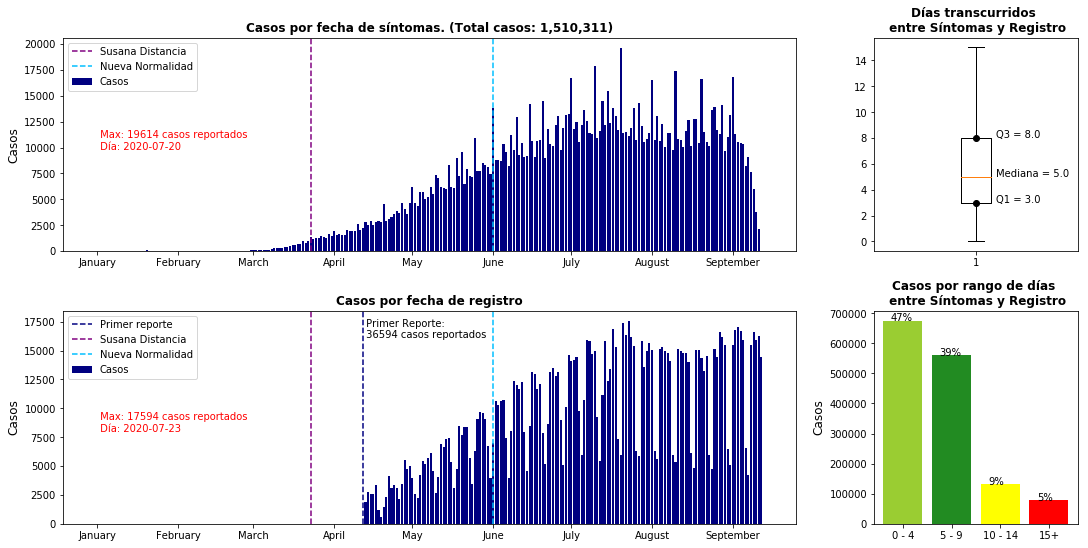

In [47]:
fig = plt.figure(constrained_layout=True,figsize=[15,7.5])

gs = GridSpec(2, 3, figure=fig)


#BARRAS: CASOS SOSPECHOSOS POR FECHA DE SINTOMAS

#Localización
ax1 = fig.add_subplot(gs[0, 0:2])

#Variables
y1=sospechosos["NUM_SINTOMAS"]
x1=sospechosos["FECHA"]

#Gráfica
ax1.bar(x1,y1,color="navy",label="Casos")

#Ejes
ax1.tick_params(labelsize=10)
#Eje X
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
#Eje y
ax1.set_ylabel("Casos", fontsize=12)

#Lineas
ax1.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax1.axvline(x=nueva_normalidad,color="deepskyblue",label="Nueva Normalidad",linestyle="--")

#Título
ax1.set_title("Casos por fecha de síntomas. (Total casos: "+ str(total_registros)+")",
              fontsize=12, weight="bold")

#Textos
ax1.text("2020-01-01", max_sintomas_casos/2,
         ' Max: ' + str(max_sintomas_casos)+ " casos reportados\n Día: " +
         str(max_sintomas_fecha)[:10],fontsize=10,color="red")

#Leyenda
ax1.legend()


#BARRAS: CASOS SOSPECHOS POR FECHA DE REGISTRO
#Localización
ax2 = fig.add_subplot(gs[1, 0:2])

#Variables
y2=sospechosos["NUM_REGISTROS"]

#Gráfica
ax2.bar(x1,y2,color="navy",label="Casos")

#Ejes
ax2.tick_params(labelsize=10)
#Eje X
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
#Eje y
ax2.set_ylabel("Casos", fontsize=12)

#Líneas
ax2.axvline(x=fecha_primer_reporte,color="navy",label="Primer reporte",linestyle="--")
ax2.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax2.axvline(x=nueva_normalidad,color="deepskyblue",label="Nueva Normalidad",linestyle="--")

#Título
ax2.set_title("Casos por fecha de registro", fontsize=12,weight="bold")

#Textos
ax2.text(fecha_primer_reporte, max_registros_casos-1500, ' Primer Reporte: \n ' + 
         str(registros_primer_reporte)+ " casos reportados")
ax2.text("2020-01-01", 8000,
         ' Max: ' + str(max_registros_casos)+ " casos reportados\n Día: " +
         str(max_registros_fecha)[:10],color="red")

#Leyenda
ax2.legend()


#TIEMPO TRANSCURRIDO ENTRE SÍNTOMAS Y REGISTRO
ax3 = fig.add_subplot(gs[0, 2])
dias1=Rt["T1"].dropna()

data=([dias1])

ax3.boxplot(data,0,"")

q1 = Rt["T1"].quantile(0.25)
q2 = Rt["T1"].quantile(0.5)
q3 = Rt["T1"].quantile(0.75)
ax3.scatter(1, q1, c='k', label='Q1')
ax3.text(1.1, q1, "Q1 = {0}".format(q1))

ax3.text(1.1, q2, "Mediana = {0}".format(q2))
ax3.scatter(1, q3, c='k', label='Q3')
ax3.text(1.1, q3, "Q3 = {0}".format(q3))

ax3.set_title("Días transcurridos \n entre Síntomas y Registro", fontsize=12, weight="bold")

#TIEMPO TRANSCURRIDO ENTRE SÍNTOMAS Y REGISTRO (BARRAS)
y4=T1_rango["NUM_CASOS"]

x4=T1_rango["T1_RANGO"]

labels4 = T1_rango["%_CASOS"]

colors=["yellowgreen","forestgreen","yellow","red"]

ax4 = fig.add_subplot(gs[1, 2])

rects = ax4.patches
ax4.bar(x4,y4,color=colors)

ax4.set_ylabel("Casos", fontsize=12)
ax4.tick_params(labelsize=10)

xlocs=[i for i in range(0,4)]
for i, v in enumerate(y4):
    plt.text(xlocs[i] - 0.25, v + 0.01, "{:.0%}".format(labels4[i]))
    
ax4.set_title("Casos por rango de días \n entre Síntomas y Registro", fontsize=12, weight="bold")

plt.savefig("Images/Casos.png")

plt.show()

## RESULTADOS DE PRUEBAS
### Positividad

Cómo se comparan los resultados positivos Vs los negativos en los diferentes momentos de la pandemia

Cuántos casos han sido positivos, cuántos negativos y cuántos esperan resultado

In [48]:
#Filtrar información para análisis de positivdad
base_positividad=Rt.loc[:,["RX_RESULTADO","R2_FECHA","FECHA_SINTOMAS","RX_FECHA","ID_REGISTRO","T2_RANGO","T1",
                     "T1_RANGO","R1_FECHA"]]
base_positividad.head()

,RX_RESULTADO,R2_FECHA,FECHA_SINTOMAS,RX_FECHA,ID_REGISTRO,T2_RANGO,T1,T1_RANGO,R1_FECHA
0,Positivo SARS-CoV-2,2020-07-08,2020-06-29,2020-09-12,114cd3,0 - 3,7,5 - 9,2020-07-06
1,Positivo SARS-CoV-2,2020-05-01,2020-04-28,2020-09-12,0bafd8,0 - 3,1,0 - 4,2020-04-29
2,Positivo SARS-CoV-2,2020-04-20,2020-04-10,2020-09-12,18747a,4 - 7,5,5 - 9,2020-04-15
3,Positivo SARS-CoV-2,2020-04-23,2020-04-11,2020-09-12,174174,0 - 3,12,10 - 14,2020-04-23
4,Positivo SARS-CoV-2,2020-04-27,2020-04-21,2020-09-12,0eae86,0 - 3,6,5 - 9,2020-04-27


#### Positividad Acumulada 

In [49]:
positividad_acumulada=base_positividad.loc[:,["ID_REGISTRO","RX_RESULTADO"]]
positividad_acumulada=positividad_acumulada.groupby(["RX_RESULTADO"],as_index=False).count()
positividad_acumulada=positividad_acumulada.loc[positividad_acumulada["RX_RESULTADO"]!="Resultado pendiente"]
positividad_acumulada=positividad_acumulada.rename(columns={"ID_REGISTRO":"NUM_CASOS"})
positividad_acumulada

,RX_RESULTADO,NUM_CASOS
0,No positivo SARS-CoV-2,759215
1,Positivo SARS-CoV-2,664106


#### Relacionado a Fechas
1. Por fecha de registro del caso (R1)

In [50]:
aux_positividad_R1=base_positividad.loc[:,["ID_REGISTRO","RX_RESULTADO","R1_FECHA"]]
aux_positividad_R1=aux_positividad_R1.groupby(["R1_FECHA","RX_RESULTADO"],as_index=False).count()
#aux_poisitividad_R1.head()

#CASOS POSITIVOS
positividad_R1_covid=aux_positividad_R1.loc[aux_positividad_R1["RX_RESULTADO"]=="Positivo SARS-CoV-2"]
positividad_R1_covid=positividad_R1_covid.rename(columns={"ID_REGISTRO":"COVID_REGISTRO"})
positividad_R1_covid=positividad_R1_covid.loc[:,["R1_FECHA","COVID_REGISTRO"]]
#positividad_R1_covid.head()

#CASOS NEGATIVOS
positividad_R1_nocovid=aux_positividad_R1.loc[aux_positividad_R1["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
positividad_R1_nocovid=positividad_R1_nocovid.rename(columns={"ID_REGISTRO":"NO_COVID_REGISTRO"})
positividad_R1_nocovid=positividad_R1_nocovid.loc[:,["R1_FECHA","NO_COVID_REGISTRO"]]
#positividad_R1_nocovid.head()

#Agrupar casos positivos y negativos en una tabla
positividad_R1=positividad_R1_covid.merge(positividad_R1_nocovid,on="R1_FECHA",how="outer").fillna(0)
positividad_R1["%_POSITIVIDAD_REGISTRO"]=positividad_R1["COVID_REGISTRO"]/(positividad_R1["COVID_REGISTRO"]+positividad_R1["NO_COVID_REGISTRO"])*100
positividad_R1=positividad_R1.rename(columns={"R1_FECHA":"FECHA"})
positividad_R1.head()

positividad_R1.tail()

,FECHA,COVID_REGISTRO,NO_COVID_REGISTRO,%_POSITIVIDAD_REGISTRO
149,2020-09-08,5410.0,7345.0,42.414739
150,2020-09-09,4680.0,6981.0,40.133779
151,2020-09-10,3013.0,4609.0,39.530307
152,2020-09-11,1771.0,2099.0,45.762274
153,2020-09-12,502.0,427.0,54.036598


2. Por Fecha de Síntomas

In [51]:
aux_positividad_sintomas=base_positividad.loc[:,["ID_REGISTRO","RX_RESULTADO","FECHA_SINTOMAS"]]
aux_positividad_sintomas=aux_positividad_sintomas.groupby(["FECHA_SINTOMAS","RX_RESULTADO"],as_index=False).count()

#CASOS POSITIVOS
positividad_sintomas_covid=aux_positividad_sintomas.loc[aux_positividad_sintomas["RX_RESULTADO"]=="Positivo SARS-CoV-2"]
positividad_sintomas_covid=positividad_sintomas_covid.rename(columns={"ID_REGISTRO":"COVID_SINTOMAS"})
positividad_sintomas_covid=positividad_sintomas_covid.loc[:,["FECHA_SINTOMAS","COVID_SINTOMAS"]]
#positividad_sintomas_covid.head()

#CASOS NEGATIVOS
positividad_sintomas_nocovid=aux_positividad_sintomas.loc[aux_positividad_sintomas["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
positividad_sintomas_nocovid=positividad_sintomas_nocovid.rename(columns={"ID_REGISTRO":"NO_COVID_SINTOMAS"})
positividad_sintomas_nocovid=positividad_sintomas_nocovid.loc[:,["FECHA_SINTOMAS","NO_COVID_SINTOMAS"]]
#positividad_sintomas_nocovid.head()

#Agrupar casos positivos y negativos en una tabla
positividad_sintomas=positividad_sintomas_covid.merge(positividad_sintomas_nocovid,on="FECHA_SINTOMAS",how="outer").fillna(0)
positividad_sintomas["%_POSITIVIDAD_SINTOMAS"]=positividad_sintomas["COVID_SINTOMAS"]/(positividad_sintomas["COVID_SINTOMAS"]+positividad_sintomas["NO_COVID_SINTOMAS"])*100
positividad_sintomas=positividad_sintomas.rename(columns={"FECHA_SINTOMAS":"FECHA"})
positividad_sintomas.head()

,FECHA,COVID_SINTOMAS,NO_COVID_SINTOMAS,%_POSITIVIDAD_SINTOMAS
0,2020-01-01,0.0,21.0,0.0
1,2020-01-02,0.0,20.0,0.0
2,2020-01-03,0.0,16.0,0.0
3,2020-01-04,0.0,19.0,0.0
4,2020-01-05,0.0,26.0,0.0


3. Por fecha de Resultado

In [52]:
aux_positividad_R2=base_positividad.loc[:,["ID_REGISTRO","RX_RESULTADO","R2_FECHA"]]
aux_positividad_R2=aux_positividad_R2.groupby(["R2_FECHA","RX_RESULTADO"],as_index=False).count()
#aux_positividad_R2.tail()

#CASOS POSITIVOS
positividad_R2_covid=aux_positividad_R2.loc[aux_positividad_R2["RX_RESULTADO"]=="Positivo SARS-CoV-2"]
positividad_R2_covid=positividad_R2_covid.rename(columns={"ID_REGISTRO":"COVID_RESULTADO"})
positividad_R2_covid=positividad_R2_covid.loc[:,["R2_FECHA","COVID_RESULTADO"]]
#positividad_R2_covid.head()

#CASOS NEGATIVOS
positividad_R2_nocovid=aux_positividad_R2.loc[aux_positividad_R2["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
positividad_R2_nocovid=positividad_R2_nocovid.rename(columns={"ID_REGISTRO":"NO_COVID_RESULTADO"})
positividad_R2_nocovid=positividad_R2_nocovid.loc[:,["R2_FECHA","NO_COVID_RESULTADO"]]
positividad_R2_nocovid.head()

#Agrupar casos positivos y negativos en una tabla
positividad_R2=positividad_R2_covid.merge(positividad_R2_nocovid,on="R2_FECHA",how="outer").fillna(0)
positividad_R2["%_POSITIVIDAD_RESULTADO"]=positividad_R2["COVID_RESULTADO"]/(positividad_R2["COVID_RESULTADO"]+positividad_R2["NO_COVID_RESULTADO"])*100
positividad_R2=positividad_R2.rename(columns={"R2_FECHA":"FECHA"})
positividad_R2.head()

,FECHA,COVID_RESULTADO,NO_COVID_RESULTADO,%_POSITIVIDAD_RESULTADO
0,2020-04-12,4662.0,21654.0,17.715458
1,2020-04-13,361.0,1030.0,25.952552
2,2020-04-14,395.0,880.0,30.980392
3,2020-04-15,451.0,1247.0,26.560660
4,2020-04-16,473.0,1363.0,25.762527


Agrupar tablas de positividad por fecha de registro, síntomas y resultado

In [53]:
positividad_total=positividad_sintomas.merge(positividad_R1,on=["FECHA"],how="outer")
positividad_total=positividad_total.merge(positividad_R2,on=["FECHA"],how="outer")

positividad_total=positividad_total.sort_values(by=["FECHA"])
positividad_total.tail()

,FECHA,COVID_SINTOMAS,NO_COVID_SINTOMAS,%_POSITIVIDAD_SINTOMAS,COVID_REGISTRO,NO_COVID_REGISTRO,%_POSITIVIDAD_REGISTRO,COVID_RESULTADO,NO_COVID_RESULTADO,%_POSITIVIDAD_RESULTADO
251,2020-09-08,754.0,1935.0,28.040164,5410.0,7345.0,42.414739,5376.0,7871.0,40.582773
252,2020-09-09,316.0,921.0,25.545675,4680.0,6981.0,40.133779,4689.0,6901.0,40.457291
253,2020-09-10,78.0,186.0,29.545455,3013.0,4609.0,39.530307,4871.0,7645.0,38.918185
254,2020-09-11,2.0,41.0,4.651163,1771.0,2099.0,45.762274,5981.0,8583.0,41.067015
255,2020-09-12,0.0,0.0,NaN,502.0,427.0,54.036598,5683.0,8421.0,40.293534


#### Relacionado al tiempo entre síntomas y registro del caso

1. Acumulado por días entre síntomas y registro

In [54]:
aux_positividad_T1=base_positividad.loc[:,["ID_REGISTRO","R1_FECHA","FECHA_SINTOMAS","RX_RESULTADO","T1"]]

#Descartar primer reporte (evitar distorsiones por ser el primer reporte)
descarte_aux_positividad_T1=aux_positividad_T1.loc[aux_positividad_T1["R1_FECHA"]==fecha_primer_reporte]
aux_positividad_T1=aux_positividad_T1.loc[aux_positividad_T1["R1_FECHA"]!=fecha_primer_reporte]
aux_positividad_T1=aux_positividad_T1.sort_values(by=["T1"])
#descarte_aux_positividad_registro_T1.groupby(["RX_RESULTADO"]).count()
#aux_positividad_T1.head()

#CASOS POSITIVOS
positividad_T1_covid=aux_positividad_T1.loc[aux_positividad_T1["RX_RESULTADO"]=="Positivo SARS-CoV-2"]
positividad_T1_covid=positividad_T1_covid.groupby(["T1"],as_index=False).count()
positividad_T1_covid=positividad_T1_covid.loc[:,["T1","ID_REGISTRO"]]
positividad_T1_covid=positividad_T1_covid.dropna(subset=["ID_REGISTRO"])
positividad_T1_covid=positividad_T1_covid.rename(columns={"ID_REGISTRO":"COVID_T1"})
#positividad_T1_covid.head()

#CASOS NEGATIVOS
positividad_T1_nocovid=aux_positividad_T1.loc[aux_positividad_T1["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
positividad_T1_nocovid=positividad_T1_nocovid.groupby(["T1"],as_index=False).count()
positividad_T1_nocovid=positividad_T1_nocovid.loc[:,["T1","ID_REGISTRO"]]
positividad_T1_nocovid=positividad_T1_nocovid.dropna(subset=["ID_REGISTRO"])
positividad_T1_nocovid=positividad_T1_nocovid.rename(columns={"ID_REGISTRO":"NO_COVID_T1"})
positividad_T1_nocovid.head()

#Agrupar casos positivos y negativos
positividad_T1_total=positividad_T1_covid.merge(positividad_T1_nocovid,on=["T1"],how="outer")

positividad_T1_total["POSITIVIDAD_T1"]=positividad_T1_total["COVID_T1"]/(positividad_T1_total["COVID_T1"]+positividad_T1_total["NO_COVID_T1"])*100
positividad_T1_total.head()

,T1,COVID_T1,NO_COVID_T1,POSITIVIDAD_T1
0,0,8063.0,25410.0,24.088071
1,1,36236.0,90598.0,28.569626
2,2,55102.0,94873.0,36.740790
3,3,73498.0,103972.0,41.414324
4,4,85777.0,100393.0,46.074556


2. Por Rango de tiempo transcurrido entre síntomas y registro

In [55]:
aux_positividad_rango_T1=base_positividad.loc[:,["ID_REGISTRO","R1_FECHA","FECHA_SINTOMAS","RX_RESULTADO","T1_RANGO","T1"]]

#Descartar primer reporte (evitar distorsiones por ser el primer reporte)
descarte_aux_positividad_T1=aux_positividad_rango_T1.loc[aux_positividad_rango_T1["R1_FECHA"]==fecha_primer_reporte]
aux_positividad_rango_T1=aux_positividad_rango_T1.loc[aux_positividad_rango_T1["R1_FECHA"]!=fecha_primer_reporte]
aux_positividad_rango_T1=aux_positividad_rango_T1.sort_values(by=["T1_RANGO"])
#descarte_aux_positividad_registro_rango_T1.groupby(["RX_RESULTADO"]).count()
#aux_positividad_rango_T1.head()

#CASOS POSITIVOS
positividad_rango_T1_covid=aux_positividad_rango_T1.loc[aux_positividad_T1["RX_RESULTADO"]=="Positivo SARS-CoV-2"]
positividad_rango_T1_covid=positividad_rango_T1_covid.groupby(["FECHA_SINTOMAS","T1_RANGO"],as_index=False).count()
positividad_rango_T1_covid=positividad_rango_T1_covid.loc[:,["FECHA_SINTOMAS","T1_RANGO","ID_REGISTRO"]]
positividad_rango_T1_covid=positividad_rango_T1_covid.dropna(subset=["ID_REGISTRO"])
positividad_rango_T1_covid=positividad_rango_T1_covid.rename(columns={"ID_REGISTRO":"COVID_RANGO_T1"})
#positividad_rango_T1_covid.head()

#CASOS NEGATIVOS
positividad_rango_T1_nocovid=aux_positividad_rango_T1.loc[aux_positividad_T1["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
positividad_rango_T1_nocovid=positividad_rango_T1_nocovid.groupby(["FECHA_SINTOMAS","T1_RANGO"],as_index=False).count()
positividad_rango_T1_nocovid=positividad_rango_T1_nocovid.loc[:,["FECHA_SINTOMAS","T1_RANGO","ID_REGISTRO"]]
positividad_rango_T1_nocovid=positividad_rango_T1_nocovid.dropna(subset=["ID_REGISTRO"])
positividad_rango_T1_nocovid=positividad_rango_T1_nocovid.rename(columns={"ID_REGISTRO":"NO_COVID_RANGO_T1"})
positividad_rango_T1_nocovid.head()

#Agrupar casos positivos y negativos
positividad_rango_T1_total=positividad_rango_T1_covid.merge(positividad_rango_T1_nocovid,
                                                                        on=["FECHA_SINTOMAS","T1_RANGO"],
                                                                        how="outer")

positividad_rango_T1_total["POSITIVIDAD_RANGO_T1"]=positividad_rango_T1_total["COVID_RANGO_T1"]/(positividad_rango_T1_total["COVID_RANGO_T1"]+positividad_rango_T1_total["NO_COVID_RANGO_T1"])*100
positividad_rango_T1_total = positividad_rango_T1_total.pivot(index='FECHA_SINTOMAS', columns='T1_RANGO', values='POSITIVIDAD_RANGO_T1')
positividad_rango_T1_total.head()

T1_RANGO,0 - 4,5 - 9,10 - 14,15+
FECHA_SINTOMAS,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN


In [56]:
aux_positividad_T2=base_positividad.loc[:,["ID_REGISTRO","R2_FECHA","FECHA_SINTOMAS","RX_RESULTADO","T2_RANGO","T2"]]

#Descartar primer reporte (evitar distorsiones por ser el primer reporte)
descarte_aux_positividad_T2=aux_positividad_T2.loc[aux_positividad_T2["R2_FECHA"]==fecha_primer_reporte]
aux_positividad_T2=aux_positividad_T2.loc[aux_positividad_T2["R2_FECHA"]!=fecha_primer_reporte]
aux_positividad_T2=aux_positividad_T2.sort_values(by=["T2_RANGO"])
#descarte_aux_positividad_registro_T2.groupby(["RX_RESULTADO"]).count()
#aux_positividad_T2.head()

#CASOS POSITIVOS
positividad_rango_T2_covid=aux_positividad_T2.loc[aux_positividad_T2["RX_RESULTADO"]=="Positivo SARS-CoV-2"]
positividad_rango_T2_covid=positividad_rango_T2_covid.groupby(["FECHA_SINTOMAS","T2_RANGO"],as_index=False).count()
positividad_rango_T2_covid=positividad_rango_T2_covid.loc[:,["FECHA_SINTOMAS","T2_RANGO","ID_REGISTRO"]]
positividad_rango_T2_covid=positividad_rango_T2_covid.dropna(subset=["ID_REGISTRO"])
positividad_rango_T2_covid=positividad_rango_T2_covid.rename(columns={"ID_REGISTRO":"COVID_RANGO_T2"})
#positividad_rango_T2_covid.head()

#CASOS NEGATIVOS
positividad_rango_T2_nocovid=aux_positividad_T2.loc[aux_positividad_T2["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
positividad_rango_T2_nocovid=positividad_rango_T2_nocovid.groupby(["FECHA_SINTOMAS","T2_RANGO"],as_index=False).count()
positividad_rango_T2_nocovid=positividad_rango_T2_nocovid.loc[:,["FECHA_SINTOMAS","T2_RANGO","ID_REGISTRO"]]
positividad_rango_T2_nocovid=positividad_rango_T2_nocovid.dropna(subset=["ID_REGISTRO"])
positividad_rango_T2_nocovid=positividad_rango_T2_nocovid.rename(columns={"ID_REGISTRO":"NO_COVID_RANGO_T2"})
positividad_rango_T2_nocovid.head()

#Agrupar casos positivos y negativos
positividad_rango_T2_total=positividad_rango_T2_covid.merge(positividad_rango_T2_nocovid,
                                                                        on=["FECHA_SINTOMAS","T2_RANGO"],
                                                                        how="outer")

positividad_rango_T2_total["POSITIVIDAD_RANGO_T2"]=positividad_rango_T2_total["COVID_RANGO_T2"]/(positividad_rango_T2_total["COVID_RANGO_T2"]+positividad_rango_T2_total["NO_COVID_RANGO_T2"])*100
positividad_rango_T2_total = positividad_rango_T2_total.pivot(index='FECHA_SINTOMAS', columns='T2_RANGO', values='POSITIVIDAD_RANGO_T2')
positividad_rango_T2_total.head()

C:\Users\varicoj\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


T2_RANGO,0 - 3,4 - 7,8 - 14,15+
FECHA_SINTOMAS,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN


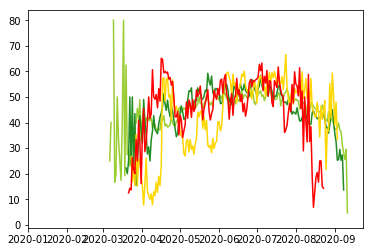

In [57]:
plt.plot(positividad_rango_T2_total.index,positividad_rango_T2_total["0 - 3"],color="yellowgreen")
plt.plot(positividad_rango_T2_total.index,positividad_rango_T2_total["4 - 7"],color="forestgreen")
plt.plot(positividad_rango_T2_total.index,positividad_rango_T2_total["8 - 14"],color="gold")
plt.plot(positividad_rango_T2_total.index,positividad_rango_T2_total["15+"],color="red")

In [58]:
positividad_T1_total.head()

,T1,COVID_T1,NO_COVID_T1,POSITIVIDAD_T1
0,0,8063.0,25410.0,24.088071
1,1,36236.0,90598.0,28.569626
2,2,55102.0,94873.0,36.740790
3,3,73498.0,103972.0,41.414324
4,4,85777.0,100393.0,46.074556


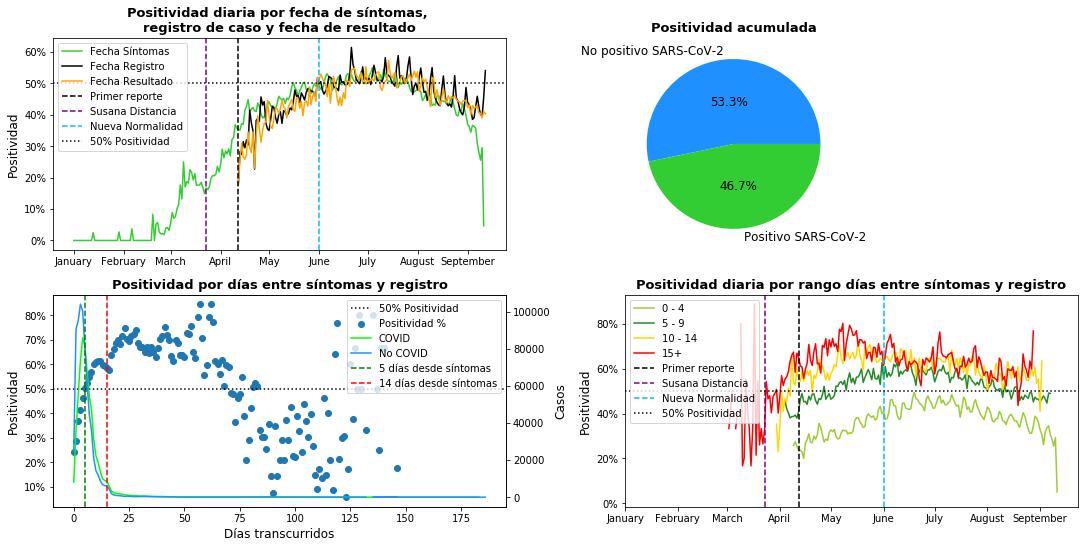

In [59]:
fig = plt.figure(constrained_layout=True,figsize=[15,7.5])

gs = GridSpec(2, 4, figure=fig)

#POSITIVIDAD POR DÍAS TRANSCURRIDOS ENTRE SÍNTOMAS Y REGISTRO
ax1 = fig.add_subplot(gs[1, 0:2])

ax1.scatter(positividad_T1_total["T1"],positividad_T1_total["POSITIVIDAD_T1"], label="Positividad %")

ax1.legend(loc='lower left')

ax1.set_xlabel("Días transcurridos", fontsize=12)

ax1.axhline(y=50,color="black",linestyle=":",label="50% Positividad")
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))
ax1.set_ylabel("Positividad", fontsize=12)

ax2=ax1.twinx()
ax2.plot(positividad_T1_total["T1"],positividad_T1_total["COVID_T1"], label="COVID",color="lime")
ax2.plot(positividad_T1_total["T1"],positividad_T1_total["NO_COVID_T1"], label="No COVID", color="dodgerblue")

ax2.set_ylabel("Casos", fontsize=12)

ax2.axvline(x=5,color="green",linestyle="--", label="5 días desde síntomas")
ax2.axvline(x=15,color="red",linestyle="--", label="14 días desde síntomas")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper right")
ax1.set_title("Positividad por días entre síntomas y registro", fontsize=13, weight="bold")

#POSITIVIDAD DIARIA POR RANGO DE TIEMPO TRANSCURRIDO ENTRE SÍNTOMAS Y REGISTRO

ax3 = fig.add_subplot(gs[1, 2:4])


y1=positividad_rango_T1_total["0 - 4"]
y2=positividad_rango_T1_total["5 - 9"]
y3=positividad_rango_T1_total["10 - 14"]
y4=positividad_rango_T1_total["15+"]

x1=positividad_rango_T1_total.index

ax3.plot(x1,y1,color="yellowgreen")
ax3.plot(x1,y2,color="forestgreen")
ax3.plot(x1,y3,color="gold")
ax3.plot(x1,y4,color="red")


ax3.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax3.xaxis.set_major_locator(mdates.MonthLocator())

ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))
ax3.set_ylabel("Positividad", fontsize=12)

ax3.tick_params(labelsize=10)

ax3.set_title("Positividad diaria por rango días entre síntomas y registro", fontsize=13, weight="bold")

ax3.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")
ax3.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax3.axvline(x=nueva_normalidad,color="deepskyblue",label="Nueva Normalidad",linestyle="--")

ax3.axhline(y=50,color="black",linestyle=":",label="50% Positividad")

ax3.legend()

#POSITIVIDAD POR FECHA DE SÍNTOMAS, REGISTRO Y RESULTADO

ax4 = fig.add_subplot(gs[0, 0:2])

ax4.plot(positividad_total["FECHA"],positividad_total["%_POSITIVIDAD_SINTOMAS"],color="limegreen", label="Fecha Síntomas")
ax4.plot(positividad_total["FECHA"],positividad_total["%_POSITIVIDAD_REGISTRO"],color="black", label = "Fecha Registro")
ax4.plot(positividad_total["FECHA"],positividad_total["%_POSITIVIDAD_RESULTADO"],color="orange", label ="Fecha Resultado")

ax4.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")
ax4.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax4.axvline(x=nueva_normalidad,color="deepskyblue",label="Nueva Normalidad",linestyle="--")

ax4.axhline(y=50,color="black",linestyle=":",label="50% Positividad")

ax4.set_ylabel("Positividad", fontsize=12)
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))

ax4.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax4.xaxis.set_major_locator(mdates.MonthLocator())

ax4.set_title("Positividad diaria por fecha de síntomas, \nregistro de caso y fecha de resultado", fontsize=13, weight="bold")

ax4.legend()

#POSITIVIDAD HISTÓRICA
ax5=fig.add_subplot(gs[0,2:3])

sizes=positividad_acumulada["NUM_CASOS"]
labels=positividad_acumulada["RX_RESULTADO"]

colors=["dodgerblue","limegreen"]

ax5.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',pctdistance=.5,textprops={'fontsize': 12})

ax5.set_title("Positividad acumulada", fontsize=13, weight="bold")

plt.savefig("Images/Positividad.png")


### CASOS NEGATIVOS 

In [60]:
nocovid=Rt.loc[Rt["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
nocovid.head()

,ID_REGISTRO,RX_FECHA,FECHA_SINTOMAS,RX_RESULTADO,RX_TIPO_PACIENTE,RX_INTUBADO,RX_UCI,FECHA_DEF,R1_FECHA,R1_RESULTADO,...,T2_RANGO,R3_FECHA,R3_RESULTADO,R3_TIPO_PACIENTE,T3,T3_RANGO,T4,T4_RANGO,T5,T5_RANGO
288384,1d879b,2020-09-12,2020-05-26,No positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-05-31,Resultado pendiente,...,4 - 7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288385,0a9e30,2020-09-12,2020-06-24,No positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-06-25,Resultado pendiente,...,4 - 7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288386,130eea,2020-09-12,2020-03-30,No positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-04-12,No positivo SARS-CoV-2,...,0 - 3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288387,165cd9,2020-09-12,2020-04-07,No positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-04-14,Resultado pendiente,...,4 - 7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288388,1de882,2020-09-12,2020-06-25,No positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-07-10,Resultado pendiente,...,0 - 3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Negativos por fecha del primer registro

In [61]:
#Cuándo fueron registrados los casos
nocovid_R1=nocovid.loc[:,["R1_FECHA","ID_REGISTRO","T1_RANGO"]]
nocovid_R1=nocovid_R1.groupby(["R1_FECHA","T1_RANGO"],as_index=False).count()
nocovid_R1=nocovid_R1.rename(columns={"ID_REGISTRO":"NUM_NOCOVID_R1"})

nocovid_R1=nocovid_R1.loc[nocovid_R1["R1_FECHA"]!=fecha_primer_reporte]

nocovid_R1=nocovid_R1.pivot(index='R1_FECHA', columns='T1_RANGO', values='NUM_NOCOVID_R1').rename_axis(None, axis=1)
nocovid_R1=nocovid_R1.rename(columns=str).reset_index()
#nocovid_R1.index.rename("FECHA",inplace=True)


nocovid_R1.head()

,R1_FECHA,0 - 4,5 - 9,10 - 14,15+
0,2020-04-13,733,405,107,33
1,2020-04-14,1106,604,142,48
2,2020-04-15,953,574,112,51
3,2020-04-16,1042,513,92,54
4,2020-04-17,1339,643,128,58


In [62]:
nocovid_primer_reporte

23236

2. Negativos por fecha de resultado

In [63]:
#Cuándo se entregó el resultado
nocovid_R2=nocovid.loc[:,["R2_FECHA","ID_REGISTRO","T2_RANGO"]]
nocovid_R2=nocovid_R2.groupby(["R2_FECHA","T2_RANGO"],as_index=False).count()
nocovid_R2=nocovid_R2.rename(columns={"ID_REGISTRO":"NUM_NOCOVID_R2"})

#Se descarta primer reporte, dado que los casos con resultado negativo son el acumulado hasta esta fecha
descarte_nocovid_R2=nocovid.loc[nocovid["R2_FECHA"]==fecha_primer_reporte,["ID_REGISTRO"]]
descarte_nocovid_R2=descarte_nocovid_R2["ID_REGISTRO"].count()
nocovid_R2.loc[(nocovid_R2["R2_FECHA"]==fecha_primer_reporte),"NUM_NOCOVID_R2"]=np.nan

nocovid_R2=nocovid_R2.pivot(index='R2_FECHA', columns='T2_RANGO', values='NUM_NOCOVID_R2')
nocovid_R2.index.rename("FECHA",inplace=True)
str(descarte_nocovid_R2)

#nocovid_R2.head()

'21654'

3. Total Negativos acumulados por día

In [64]:
nocovid_acumulados=db_tiempo.loc[:,["FECHA_ACTUALIZACION","RESULTADO"]]
nocovid_acumulados=nocovid_acumulados.loc[nocovid_acumulados["RESULTADO"]=="No positivo SARS-CoV-2"]
nocovid_acumulados=nocovid_acumulados.groupby(["FECHA_ACTUALIZACION"],as_index=False).count()
nocovid_acumulados=nocovid_acumulados.sort_values(by=["FECHA_ACTUALIZACION"])
nocovid_acumulados["NOCOVID_DELTA"]="pd"
nocovid_acumulados=nocovid_acumulados.rename(columns={"RESULTADO":"NOCOVID_ACUMULADOS"})
for r in range((datetime.datetime.strptime(fecha_ultimo_reporte,'%Y-%m-%d')-datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')).days+1):
    if r == 0:
        nocovid_acumulados["NOCOVID_DELTA"][r]=np.nan
        reporte_act=datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')
    else:
        reporte_prev = reporte_act
        reporte_act=reporte_act + timedelta(days=1)
        prev=nocovid_acumulados.loc[nocovid_acumulados["FECHA_ACTUALIZACION"]==reporte_prev,["NOCOVID_ACUMULADOS"]].values[0]
        act=nocovid_acumulados.loc[nocovid_acumulados["FECHA_ACTUALIZACION"]==reporte_act,["NOCOVID_ACUMULADOS"]].values[0]
        
        nocovid_acumulados.loc[(nocovid_acumulados["FECHA_ACTUALIZACION"]==reporte_act),"NOCOVID_DELTA"]=(act/prev-1)*100

nocovid_acumulados.tail()



C:\Users\varicoj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,FECHA_ACTUALIZACION,NOCOVID_ACUMULADOS,NOCOVID_DELTA
149,2020-09-08,727817,1.08836
150,2020-09-09,734649,0.938698
151,2020-09-10,742268,1.03709
152,2020-09-11,750813,1.1512
153,2020-09-12,759188,1.11546


In [65]:
nocovid_delta=nocovid_acumulados.loc[nocovid_acumulados["FECHA_ACTUALIZACION"]==fecha_ultimo_reporte,["NOCOVID_DELTA"]].values[0][0]
nocovid_delta="{:.2%}".format(nocovid_delta/100)
nocovid_delta

'1.12%'

3. Tiempo transcurrido entre síntomas y registro

In [66]:
#Cuándo sintieron los sintomas
nocovid_R1_box=nocovid.loc[:,["R1_FECHA","T1","ID_REGISTRO"]]

#Descartar primer reporte
nocovid_R1_box=nocovid_R1_box.loc[(nocovid_R1_box["R1_FECHA"]!=fecha_primer_reporte)]

nocovid_R1_box=nocovid_R1_box.sort_values(by=["R1_FECHA"])
nocovid_R1_box.head()

,R1_FECHA,T1,ID_REGISTRO
608033,2020-04-13,3,1dd77e
336045,2020-04-13,4,14c32e
336044,2020-04-13,1,09ce76
560013,2020-04-13,3,1a1caa
560014,2020-04-13,5,0a619c


4. Tiempo transcurrido entre registro y resultado

In [67]:
#Cuándo sintieron los sintomas
nocovid_R2_box=nocovid.loc[:,["R1_FECHA","T2","ID_REGISTRO"]]

#Descartar primer reporte
nocovid_R2_box=nocovid_R2_box.loc[(nocovid_R2_box["R1_FECHA"]!=fecha_primer_reporte)]

nocovid_R2_box=nocovid_R2_box.sort_values(by=["R1_FECHA"])
nocovid_R2_box.head()

,R1_FECHA,T2,ID_REGISTRO
608033,2020-04-13,4.0,1dd77e
336045,2020-04-13,1.0,14c32e
336044,2020-04-13,1.0,09ce76
560013,2020-04-13,8.0,1a1caa
560014,2020-04-13,1.0,0a619c


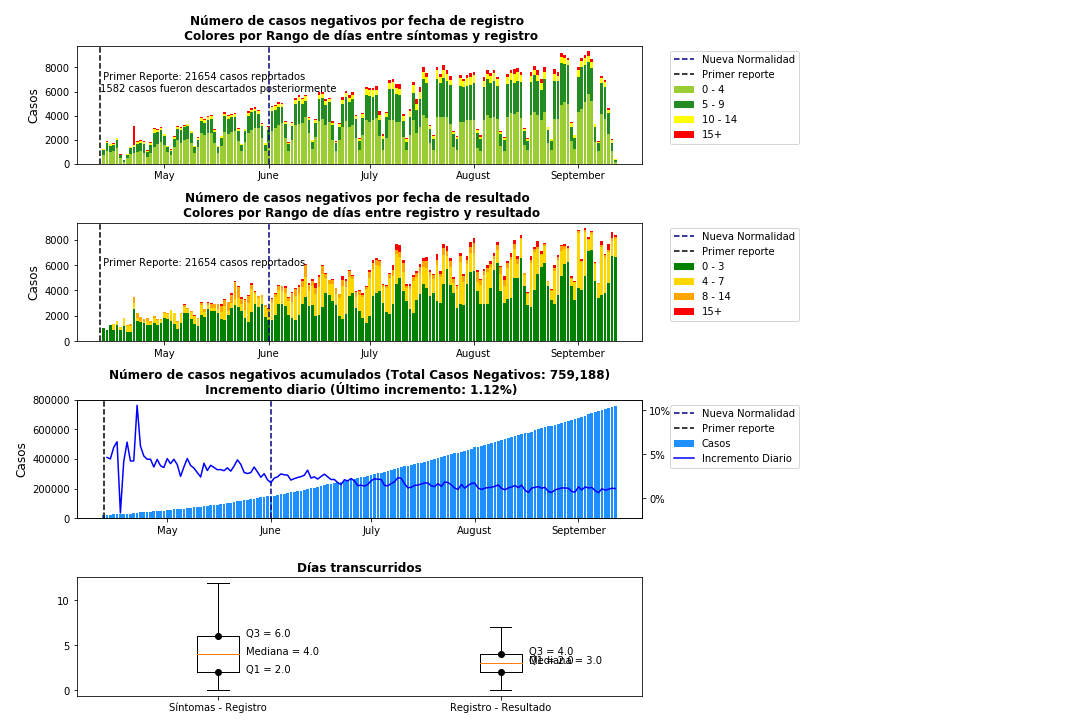

In [68]:
fig = plt.figure(constrained_layout=True,figsize=[15,10])

gs = GridSpec(4, 4, figure=fig)


#BARRAS: CASOS NEGATIVOS POR FECHA DE REGISTRO, COLORES POR RANGO DE DÍAS ENTRE SÍNTOMAS Y REGISTRO
y1=nocovid_R1["0 - 4"]
y2=nocovid_R1["5 - 9"]
y3=nocovid_R1["10 - 14"]
y4=nocovid_R1["15+"]

aux_y1y2=np.add(nocovid_R1["0 - 4"],nocovid_R1["5 - 9"]).tolist()
aux_y1y2y3=np.add(aux_y1y2,nocovid_R1["10 - 14"]).tolist()

x1=nocovid_R1["R1_FECHA"]
colors=["yellowgreen","forestgreen","yellow","red"]

ax1 = fig.add_subplot(gs[0, 0:])
ax1.bar(x1,y1,color="yellowgreen",label="0 - 4")
ax1.bar(x1,y2,color="forestgreen",bottom=y1,label="5 - 9")
ax1.bar(x1,y3,color="yellow",bottom=aux_y1y2,label="10 - 14")
ax1.bar(x1,y4,color="red",bottom=aux_y1y2y3,label="15+")

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_ylabel("Casos", fontsize=12)
ax1.tick_params(labelsize=10)

#ax1.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax1.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
ax1.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax1.text(fecha_primer_reporte, 6000, ' Primer Reporte: ' + str(descarte_nocovid_R2)+ " casos reportados \n" +
        str(nocovid_primer_reporte - descarte_nocovid_R2)+" casos fueron descartados posteriormente")

ax1.set_title("Número de casos negativos por fecha de registro \n Colores por Rango de días entre síntomas y registro", 
              fontsize=12, weight="bold")

ax1.legend(bbox_to_anchor=(1.04,1), loc="upper left")

#BARRAS: CASOS NEGATIVOS POR FECHA DE RESULTADO, RANGO DE COLORES POR DÍAS ENTRE REGISTRO Y OBTENCIÓN DEL RESULTADO NEGATIVO

y5=nocovid_R2["0 - 3"]
y6=nocovid_R2["4 - 7"]
y7=nocovid_R2["8 - 14"]
y8=nocovid_R2["15+"]

aux_y5y6=np.add(nocovid_R2["0 - 3"],nocovid_R2["4 - 7"]).tolist()
aux_y5y6y7=np.add(aux_y5y6,nocovid_R2["8 - 14"]).tolist()

x2=nocovid_R2.index
colors=["green","gold","orange","red"]

ax2 = fig.add_subplot(gs[1, 0:])
ax2.bar(x2,y5,color="green",label="0 - 3")
ax2.bar(x2,y6,color="gold",bottom=y5,label="4 - 7")
ax2.bar(x2,y7,color="orange",bottom=aux_y5y6,label="8 - 14")
ax2.bar(x2,y8,color="red",bottom=aux_y5y6y7,label="15+")



ax2.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.set_ylabel("Casos", fontsize=12)
ax2.tick_params(labelsize=10)

#ax2.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax2.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
ax2.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax2.text(fecha_primer_reporte, 6000, ' Primer Reporte: ' + str(descarte_nocovid_R2)+ " casos reportados")

ax2.set_title("Número de casos negativos por fecha de resultado \n Colores por Rango de días entre registro y resultado", 
              fontsize=12, weight="bold")

ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")

#CAJA: TIEMPO TRANSCURRIDO ENTRE SÍNTOMAS Y REGISTRO PARA CASOS CON RESULTADO NEGATIVO
ax3 = fig.add_subplot(gs[3, 0:])
d1=nocovid_R1_box["T1"].dropna()
d2=nocovid_R2_box["T2"].dropna()

data=([d1,d2])

ax3.boxplot(data,0,"")

q11 = nocovid_R1_box["T1"].quantile(0.25)
q12 = nocovid_R1_box["T1"].quantile(0.5)
q13 = nocovid_R1_box["T1"].quantile(0.75)
ax3.scatter(1, q11, c='k', label='Q1')
ax3.text(1.1, q11, "Q1 = {0}".format(q11))

ax3.text(1.1, q12, "Mediana = {0}".format(q12))
ax3.scatter(1, q13, c='k', label='Q3')
ax3.text(1.1, q13, "Q3 = {0}".format(q13))

q21 = nocovid_R2_box["T2"].quantile(0.25)
q22 = nocovid_R2_box["T2"].quantile(0.5)
q23 = nocovid_R2_box["T2"].quantile(0.75)
ax3.scatter(2, q21, c='k', label='Q1')
ax3.text(2.1, q1, "Q1 = {0}".format(q21))

ax3.text(2.1, q22, "Mediana = {0}".format(q22))
ax3.scatter(2, q23, c='k', label='Q3')
ax3.text(2.1, q23, "Q3 = {0}".format(q23))

ax3.set_title("Días transcurridos", fontsize=12, weight="bold")

plt.xticks([1, 2], ['Síntomas - Registro', 'Registro - Resultado'])

#BARRAS: NEGATIVOS ACUMULADOS
y9=nocovid_acumulados["NOCOVID_ACUMULADOS"]
y10=nocovid_acumulados["NOCOVID_DELTA"]

x2=nocovid_acumulados["FECHA_ACTUALIZACION"]

ax5 = fig.add_subplot(gs[2, 0:])
ax5.bar(x2,y9,color="dodgerblue",label="Casos")

ax5.set_ylabel("Casos", fontsize=12)
ax5.tick_params(labelsize=10)

#ax5.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax5.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
ax5.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax5.set_title("Número de casos negativos acumulados (Total Casos Negativos: " + str(total_negativos)+
              ")\n Incremento diario (Último incremento: "+str(nocovid_delta)+")", fontsize=12, weight="bold")

ax6=ax5.twinx()
ax6.plot(x2,y10,color="blue",label="Incremento Diario")

ax6.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))

#ax6.set_ylabel("Incremento diario", fontsize=12)

ax5.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax5.xaxis.set_major_locator(mdates.MonthLocator())
h1, l1 = ax5.get_legend_handles_labels()
h2, l2 = ax6.get_legend_handles_labels()

ax5.legend(h1+h2, l1+l2, bbox_to_anchor=(1.04,1), loc="upper left")

plt.subplots_adjust(right=0.75)
plt.tight_layout(rect=[0,0,.75,1])

plt.savefig("Images/Negativos.png")

plt.show()

### CASOS POSITIVOS

In [69]:
covid=Rt.loc[Rt["RX_RESULTADO"]=="Positivo SARS-CoV-2"]
covid.head()

,ID_REGISTRO,RX_FECHA,FECHA_SINTOMAS,RX_RESULTADO,RX_TIPO_PACIENTE,RX_INTUBADO,RX_UCI,FECHA_DEF,R1_FECHA,R1_RESULTADO,...,T2_RANGO,R3_FECHA,R3_RESULTADO,R3_TIPO_PACIENTE,T3,T3_RANGO,T4,T4_RANGO,T5,T5_RANGO
0,114cd3,2020-09-12,2020-06-29,Positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-07-06,Resultado pendiente,...,0 - 3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0bafd8,2020-09-12,2020-04-28,Positivo SARS-CoV-2,HOSPITALIZADO,SI,2,2020-05-09,2020-04-29,Resultado pendiente,...,0 - 3,2020-06-21,Positivo SARS-CoV-2,HOSPITALIZADO,43.0,+3 semanas,10.0,2 semana,11.0,2 semanas
2,18747a,2020-09-12,2020-04-10,Positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-04-15,Resultado pendiente,...,4 - 7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,174174,2020-09-12,2020-04-11,Positivo SARS-CoV-2,AMBULATORIO,NO APLICA,97,NaT,2020-04-23,Positivo SARS-CoV-2,...,0 - 3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0eae86,2020-09-12,2020-04-21,Positivo SARS-CoV-2,HOSPITALIZADO,SI,1,NaT,2020-04-27,Positivo SARS-CoV-2,...,0 - 3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Positivos por fecha del primer registro

In [70]:
#Cuándo fueron registrados los casos
covid_R1=covid.loc[:,["R1_FECHA","ID_REGISTRO","T1_RANGO"]]
covid_R1=covid_R1.groupby(["R1_FECHA","T1_RANGO"],as_index=False).count()
covid_R1=covid_R1.rename(columns={"ID_REGISTRO":"NUM_COVID_R1"})

#Se descarta primer reporte, dado que los casos con resultado negativo son el acumulado hasta esta fecha
#Considera casos reportados ya con resultado Negativo como casos pendientes que posteriormente tendrán resultado negativo
covid_R1=covid_R1.loc[covid_R1["R1_FECHA"]!=fecha_primer_reporte]

covid_R1=covid_R1.pivot(index='R1_FECHA', columns='T1_RANGO', values='NUM_COVID_R1').rename_axis(None, axis=1)
covid_R1=covid_R1.rename(columns=str).reset_index()

covid_R1["TOTAL_R1"]=covid_R1["0 - 4"]+covid_R1["5 - 9"]+covid_R1["10 - 14"]+covid_R1["15+"]

covid_R1["SUMA_7D_R1"]=covid_R1["TOTAL_R1"].rolling(7).sum()
covid_R1["MEDIA_7D_R1"]=covid_R1["TOTAL_R1"].rolling(7).mean()

covid_R1.head(10)

,R1_FECHA,0 - 4,5 - 9,10 - 14,15+,TOTAL_R1,SUMA_7D_R1,MEDIA_7D_R1
0,2020-04-13,210,226,81,14,531,NaN,NaN
1,2020-04-14,309,317,80,33,739,NaN,NaN
2,2020-04-15,313,346,114,25,798,NaN,NaN
3,2020-04-16,289,350,74,25,738,NaN,NaN
4,2020-04-17,458,450,106,43,1057,NaN,NaN
5,2020-04-18,140,170,40,12,362,NaN,NaN
6,2020-04-19,89,124,31,14,258,4483.0,640.428571
7,2020-04-20,195,233,94,23,545,4497.0,642.428571
8,2020-04-21,326,334,86,36,782,4540.0,648.571429
9,2020-04-22,306,438,119,66,929,4671.0,667.285714


In [71]:
for r in range((datetime.datetime.strptime(fecha_ultimo_reporte,'%Y-%m-%d')-(datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')+timedelta(days=6))).days):
    if r == 0:
        covid_R1["SUMA_7D_R1"][r]=np.nan
        reporte_act=datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')+timedelta(days=7)
        #print(reporte_act)
    else:
        reporte_prev = reporte_act-timedelta(days=6)
        reporte_act=reporte_act + timedelta(days=1)
        prev=covid_R1.loc[covid_R1["R1_FECHA"]==reporte_prev,["SUMA_7D_R1"]].values[0]
        #print(reporte_prev)
        act=covid_R1.loc[covid_R1["R1_FECHA"]==reporte_act,["SUMA_7D_R1"]].values[0]
        
        covid_R1.loc[(covid_R1["R1_FECHA"]==reporte_act),"DELTA_7D_R1"]=(act/prev-1)*100

covid_R1.tail(21)


C:\Users\varicoj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,R1_FECHA,0 - 4,5 - 9,10 - 14,15+,TOTAL_R1,SUMA_7D_R1,MEDIA_7D_R1,DELTA_7D_R1
132,2020-08-23,971,1294,260,92,2617,35235.0,5033.571429,-4.610428
133,2020-08-24,932,1017,265,141,2355,35158.0,5022.571429,-3.795321
134,2020-08-25,2340,3113,687,421,6561,35120.0,5017.142857,-3.141289
135,2020-08-26,2115,2901,642,420,6078,34856.0,4979.428571,-3.542174
136,2020-08-27,2495,3067,667,438,6667,35663.0,5094.714286,-0.416062
137,2020-08-28,2564,2672,580,379,6195,36385.0,5197.857143,3.263800
138,2020-08-29,2265,2647,597,352,5861,36334.0,5190.571429,2.609432
139,2020-08-30,943,1191,340,107,2581,36298.0,5185.428571,3.016887
140,2020-08-31,819,1074,335,121,2349,36292.0,5184.571429,3.225439
141,2020-09-01,2475,2784,799,321,6379,36110.0,5158.571429,2.818907


2. Positivos por fecha de resultado

In [72]:
#Cuándo se entregó el resultado

covid_R2=covid.loc[:,["R2_FECHA","ID_REGISTRO","T2_RANGO"]]
covid_R2=covid_R2.groupby(["R2_FECHA","T2_RANGO"],as_index=False).count()
covid_R2=covid_R2.rename(columns={"ID_REGISTRO":"NUM_COVID_R2"})

#Se descarta primer reporte, dado que los casos con resultado positivo son el acumulado hasta esta fecha

descarte_covid_R2=covid.loc[covid["R2_FECHA"]==fecha_primer_reporte,["ID_REGISTRO"]]
descarte_covid_R2=descarte_covid_R2["ID_REGISTRO"].count()

covid_R2=covid_R2.loc[covid_R2["R2_FECHA"]!=fecha_primer_reporte]

covid_R2=covid_R2.pivot(index='R2_FECHA', columns='T2_RANGO', values='NUM_COVID_R2').rename_axis(None, axis=1)
covid_R2=covid_R2.rename(columns=str).reset_index()
covid_R2=covid_R2.fillna(0)

covid_R2["TOTAL_R2"]=covid_R2["0 - 3"]+covid_R2["4 - 7"]+covid_R2["8 - 14"]+covid_R2["15+"]

covid_R2["SUMA_7D_R2"]=covid_R2["TOTAL_R2"].rolling(7).sum()
covid_R2["MEDIA_7D_R2"]=covid_R2["TOTAL_R2"].rolling(7).mean()



covid_R2.head(10)

,R2_FECHA,0 - 3,4 - 7,8 - 14,15+,TOTAL_R2,SUMA_7D_R2,MEDIA_7D_R2
0,2020-04-13,361.0,0.0,0.0,0.0,361.0,NaN,NaN
1,2020-04-14,395.0,0.0,0.0,0.0,395.0,NaN,NaN
2,2020-04-15,451.0,0.0,0.0,0.0,451.0,NaN,NaN
3,2020-04-16,411.0,62.0,0.0,0.0,473.0,NaN,NaN
4,2020-04-17,503.0,93.0,0.0,0.0,596.0,NaN,NaN
5,2020-04-18,456.0,139.0,0.0,0.0,595.0,NaN,NaN
6,2020-04-19,467.0,291.0,0.0,0.0,758.0,3629.0,518.428571
7,2020-04-20,312.0,158.0,27.0,0.0,497.0,3765.0,537.857143
8,2020-04-21,332.0,336.0,49.0,0.0,717.0,4087.0,583.857143
9,2020-04-22,648.0,339.0,55.0,0.0,1042.0,4678.0,668.285714


In [73]:
for r in range((datetime.datetime.strptime(fecha_ultimo_reporte,'%Y-%m-%d')-(datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')+timedelta(days=6))).days):
    if r == 0:
        covid_R2["SUMA_7D_R2"][r]=np.nan
        reporte_act=datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')+timedelta(days=7)
        #print(reporte_act)
    else:
        reporte_prev = reporte_act-timedelta(days=6)
        reporte_act=reporte_act + timedelta(days=1)
        prev=covid_R2.loc[covid_R2["R2_FECHA"]==reporte_prev,["MEDIA_7D_R2"]].values[0]
        #print(reporte_prev)
        act=covid_R2.loc[covid_R2["R2_FECHA"]==reporte_act,["MEDIA_7D_R2"]].values[0]
        
        covid_R2.loc[(covid_R2["R2_FECHA"]==reporte_act),"DELTA_7D_R2"]=(act/prev-1)*100

covid_R2.tail(21)

C:\Users\varicoj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,R2_FECHA,0 - 3,4 - 7,8 - 14,15+,TOTAL_R2,SUMA_7D_R2,MEDIA_7D_R2,DELTA_7D_R2
132,2020-08-23,3390.0,346.0,138.0,73.0,3947.0,37929.0,5418.428571,-9.485968
133,2020-08-24,2646.0,728.0,59.0,106.0,3539.0,37866.0,5409.428571,-5.164296
134,2020-08-25,2808.0,1545.0,209.0,329.0,4891.0,37264.0,5323.428571,-3.703129
135,2020-08-26,3114.0,1900.0,284.0,76.0,5374.0,36840.0,5262.857143,-4.683053
136,2020-08-27,4258.0,1423.0,219.0,130.0,6030.0,36130.0,5161.428571,-5.053478
137,2020-08-28,4667.0,777.0,228.0,176.0,5848.0,36152.0,5164.571429,-5.465195
138,2020-08-29,4653.0,1040.0,139.0,121.0,5953.0,35582.0,5083.142857,-7.478288
139,2020-08-30,3235.0,657.0,63.0,181.0,4136.0,35771.0,5110.142857,-5.689578
140,2020-08-31,2501.0,1170.0,61.0,67.0,3799.0,36031.0,5147.285714,-4.846036
141,2020-09-01,3272.0,2818.0,167.0,206.0,6463.0,37603.0,5371.857143,0.909725


In [74]:
covid_acumulados=db_tiempo.loc[:,["FECHA_ACTUALIZACION","RESULTADO"]]
covid_acumulados=covid_acumulados.loc[covid_acumulados["RESULTADO"]=="Positivo SARS-CoV-2"]
covid_acumulados=covid_acumulados.groupby(["FECHA_ACTUALIZACION"],as_index=False).count()
covid_acumulados=covid_acumulados.sort_values(by=["FECHA_ACTUALIZACION"])
covid_acumulados["COVID_DELTA"]="pd"
covid_acumulados=covid_acumulados.rename(columns={"RESULTADO":"COVID_ACUMULADOS"})

for r in range((datetime.datetime.strptime(fecha_ultimo_reporte,'%Y-%m-%d')-datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')).days+1):
    if r == 0:
        covid_acumulados["COVID_DELTA"][r]=np.nan
        reporte_act=datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')
    else:
        reporte_prev = reporte_act
        reporte_act=reporte_act + timedelta(days=1)
        prev=covid_acumulados.loc[covid_acumulados["FECHA_ACTUALIZACION"]==reporte_prev,["COVID_ACUMULADOS"]].values[0]
        act=covid_acumulados.loc[covid_acumulados["FECHA_ACTUALIZACION"]==reporte_act,["COVID_ACUMULADOS"]].values[0]
        
        covid_acumulados.loc[(covid_acumulados["FECHA_ACTUALIZACION"]==reporte_act),"COVID_DELTA"]=(act/prev-1)*100

covid_acumulados.tail()

C:\Users\varicoj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,FECHA_ACTUALIZACION,COVID_ACUMULADOS,COVID_DELTA
149,2020-09-08,642860,0.839361
150,2020-09-09,647507,0.722863
151,2020-09-10,652364,0.750108
152,2020-09-11,658299,0.909768
153,2020-09-12,663973,0.861918


In [75]:
covid_delta=covid_acumulados.loc[nocovid_acumulados["FECHA_ACTUALIZACION"]==fecha_ultimo_reporte,["COVID_DELTA"]].values[0][0]
covid_delta="{:.2%}".format(covid_delta/100)
covid_delta

'0.86%'

3. Tiempo transcurrido entre síntomas y registro

In [76]:
#Cuándo sintieron los sintomas

covid_R1_box=covid.loc[:,["R1_FECHA","T1","ID_REGISTRO"]]

#Descartar primer reporte
covid_R1_box=covid_R1_box.loc[(covid_R1_box["R1_FECHA"]!=fecha_primer_reporte)]
covid_R1_box=covid_R1_box.sort_values(by=["R1_FECHA"])
covid_R1_box.head()

,R1_FECHA,T1,ID_REGISTRO
103426,2020-04-13,5,1a3a16
261055,2020-04-13,4,1c431b
261054,2020-04-13,12,12e90d
61597,2020-04-13,5,0960a0
202091,2020-04-13,8,167853


4. Tiempo transcurrido entre registro y resultado

In [77]:
#Cuándo sintieron los sintomas
covid_R2_box=covid.loc[:,["R1_FECHA","T2","ID_REGISTRO"]]

#Descartar primer reporte
covid_R2_box=covid_R2_box.loc[(covid_R2_box["R1_FECHA"]!=fecha_primer_reporte)]
covid_R2_box=covid_R2_box.sort_values(by=["R1_FECHA"])

covid_R2_box.head()

,R1_FECHA,T2,ID_REGISTRO
103426,2020-04-13,2.0,1a3a16
261055,2020-04-13,7.0,1c431b
261054,2020-04-13,8.0,12e90d
61597,2020-04-13,4.0,0960a0
202091,2020-04-13,17.0,167853


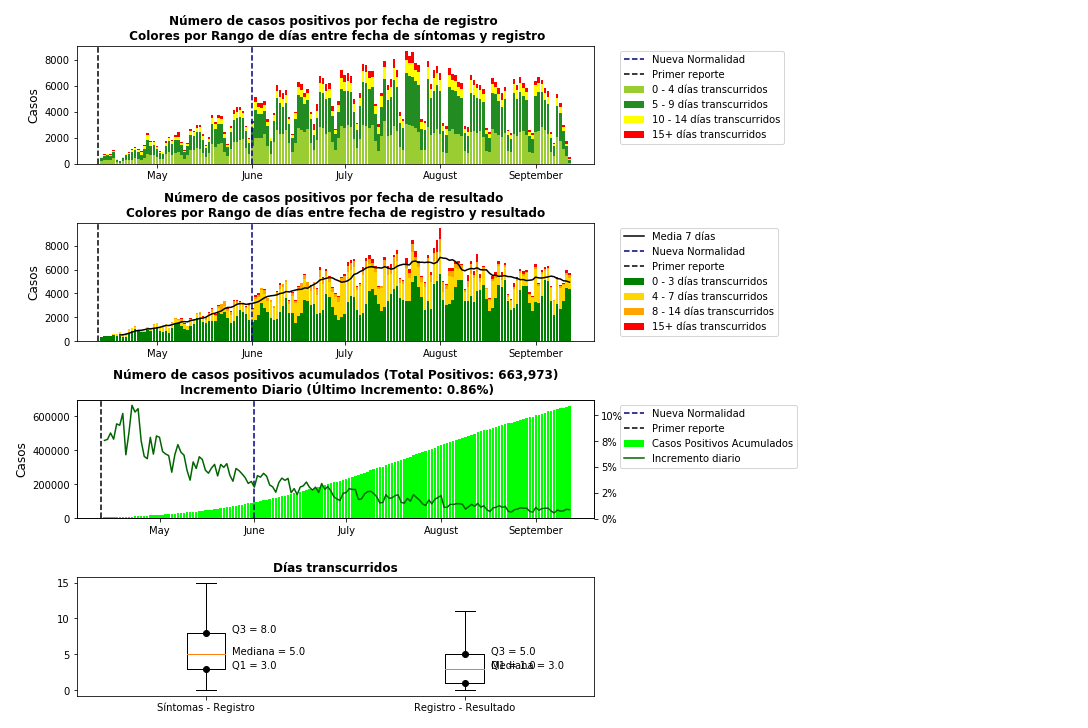

In [78]:
fig = plt.figure(constrained_layout=True,figsize=[15,10])

gs = GridSpec(4, 4, figure=fig)


#BARRAS: CASOS POSITIVOS POR FECHA DE REGISTRO, COLORES POR RANGO DE DÍAS ENTRE SÍNTOMAS Y REGISTRO
y1=covid_R1["0 - 4"]
y2=covid_R1["5 - 9"]
y3=covid_R1["10 - 14"]
y4=covid_R1["15+"]

aux_y1y2=np.add(covid_R1["0 - 4"],covid_R1["5 - 9"]).tolist()
aux_y1y2y3=np.add(aux_y1y2,covid_R1["10 - 14"]).tolist()

x1=covid_R1["R1_FECHA"]
colors=["yellowgreen","forestgreen","yellow","red"]

ax1 = fig.add_subplot(gs[0, 0:])
ax1.bar(x1,y1,color="yellowgreen",label="0 - 4 días transcurridos")
ax1.bar(x1,y2,color="forestgreen",bottom=y1,label="5 - 9 días transcurridos")
ax1.bar(x1,y3,color="yellow",bottom=aux_y1y2,label="10 - 14 días transcurridos")
ax1.bar(x1,y4,color="red",bottom=aux_y1y2y3,label="15+ días transcurridos")

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_ylabel("Casos", fontsize=12)
ax1.tick_params(labelsize=10)

#ax1.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax1.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
ax1.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax1.set_title("Número de casos positivos por fecha de registro \n "+
              "Colores por Rango de días entre fecha de síntomas y registro", fontsize=12, weight="bold")

ax1.legend(bbox_to_anchor=(1.04,1), loc="upper left")

#BARRAS: CASOS POSITIVOS POR FECHA DE RESULTADO, 
#RANGO DE COLORES POR DÍAS ENTRE REGISTRO Y OBTENCIÓN DEL RESULTADO POSITIVO

y5=covid_R2["0 - 3"]
y6=covid_R2["4 - 7"]
y7=covid_R2["8 - 14"]
y8=covid_R2["15+"]

y11=covid_R2["MEDIA_7D_R2"]

aux_y5y6=np.add(covid_R2["0 - 3"],covid_R2["4 - 7"]).tolist()
aux_y5y6y7=np.add(aux_y5y6,covid_R2["8 - 14"]).tolist()

x2=covid_R2["R2_FECHA"]
colors=["green","gold","orange","red"]

ax2 = fig.add_subplot(gs[1, 0:])
ax2.bar(x2,y5,color="green",label="0 - 3 días transcurridos")
ax2.bar(x2,y6,color="gold",bottom=y5,label="4 - 7 días transcurridos")
ax2.bar(x2,y7,color="orange",bottom=aux_y5y6,label="8 - 14 días transcurridos")
ax2.bar(x2,y8,color="red",bottom=aux_y5y6y7,label="15+ días transcurridos")

ax2.plot(x2,y11,color="black",label="Media 7 días")


ax2.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.set_ylabel("Casos", fontsize=12)
ax2.tick_params(labelsize=10)

#ax2.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax2.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
ax2.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax2.set_title("Número de casos positivos por fecha de resultado \n" +
              "Colores por Rango de días entre fecha de registro y resultado", 
              fontsize=12, weight="bold")

ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")

#CAJA: TIEMPO TRANSCURRIDO ENTRE SÍNTOMAS Y REGISTRO PARA CASOS CON RESULTADO POSITIVO
ax3 = fig.add_subplot(gs[3, 0:])
d1=covid_R1_box["T1"].dropna()
d2=covid_R2_box["T2"].dropna()

data=([d1,d2])

ax3.boxplot(data,0,"")

q11 = covid_R1_box["T1"].quantile(0.25)
q12 = covid_R1_box["T1"].quantile(0.5)
q13 = covid_R1_box["T1"].quantile(0.75)
ax3.scatter(1, q11, c='k', label='Q1')
ax3.text(1.1, q11, "Q1 = {0}".format(q11))

ax3.text(1.1, q12, "Mediana = {0}".format(q12))
ax3.scatter(1, q13, c='k', label='Q3')
ax3.text(1.1, q13, "Q3 = {0}".format(q13))

q21 = covid_R2_box["T2"].quantile(0.25)
q22 = covid_R2_box["T2"].quantile(0.5)
q23 = covid_R2_box["T2"].quantile(0.75)
ax3.scatter(2, q21, c='k', label='Q1')
ax3.text(2.1, q1, "Q1 = {0}".format(q21))

ax3.text(2.1, q22, "Mediana = {0}".format(q22))
ax3.scatter(2, q23, c='k', label='Q3')
ax3.text(2.1, q23, "Q3 = {0}".format(q23))

ax3.set_title("Días transcurridos", fontsize=12, weight="bold")

plt.xticks([1, 2], ['Síntomas - Registro', 'Registro - Resultado'])

#BARRAS: POSITIVOS ACUMULADOS
y9=covid_acumulados["COVID_ACUMULADOS"]
y10=covid_acumulados["COVID_DELTA"]

x2=covid_acumulados["FECHA_ACTUALIZACION"]

ax5 = fig.add_subplot(gs[2, 0:])
ax5.bar(x2,y9,color="lime",label="Casos Positivos Acumulados")

ax6=ax5.twinx()
ax6.plot(x2,y10,color="darkgreen",label="Incremento diario")
ax6.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))

ax5.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax5.xaxis.set_major_locator(mdates.MonthLocator())
ax5.set_ylabel("Casos", fontsize=12)
ax5.tick_params(labelsize=10)

#ax5.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax5.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
ax5.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax5.set_title("Número de casos positivos acumulados (Total Positivos: "+str(total_positivos)+
              ")\n Incremento Diario (Último Incremento: "+str(covid_delta)+")", fontsize=12, weight="bold")

h1, l1 = ax5.get_legend_handles_labels()
h2, l2 = ax6.get_legend_handles_labels()
ax5.legend(h1+h2, l1+l2, bbox_to_anchor=(1.04,1),loc="upper left")

plt.subplots_adjust(right=0.75)
plt.tight_layout(rect=[0,0,.75,1])

plt.savefig("Images/Positivos.png")

plt.show()

### Casos Pendientes

In [79]:
pendiente=Rt.loc[Rt["RX_RESULTADO"]=="Resultado pendiente"]
pendiente.head()

,ID_REGISTRO,RX_FECHA,FECHA_SINTOMAS,RX_RESULTADO,RX_TIPO_PACIENTE,RX_INTUBADO,RX_UCI,FECHA_DEF,R1_FECHA,R1_RESULTADO,...,T2_RANGO,R3_FECHA,R3_RESULTADO,R3_TIPO_PACIENTE,T3,T3_RANGO,T4,T4_RANGO,T5,T5_RANGO
619709,15c450,2020-09-12,2020-06-24,Resultado pendiente,HOSPITALIZADO,NO,2,2020-06-25,2020-06-27,Resultado pendiente,...,NaN,2020-08-21,Resultado pendiente,HOSPITALIZADO,57.0,+3 semanas,-2.0,Def antes de registro,1.0,3 días
619710,0f5e2d,2020-09-12,2020-05-26,Resultado pendiente,AMBULATORIO,NO APLICA,97,NaT,2020-06-03,Resultado pendiente,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619711,129b23,2020-09-12,2020-05-13,Resultado pendiente,AMBULATORIO,NO APLICA,97,NaT,2020-08-25,Resultado pendiente,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619712,17bf88,2020-09-12,2020-05-28,Resultado pendiente,HOSPITALIZADO,NO,2,NaT,2020-06-09,Resultado pendiente,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619713,1f94f0,2020-09-12,2020-05-30,Resultado pendiente,AMBULATORIO,NO APLICA,97,NaT,2020-09-10,Resultado pendiente,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Pendientes por fecha de registro

In [80]:
#Cuándo fueron registrados los casos
pendiente_R1=pendiente.loc[:,["R1_FECHA","ID_REGISTRO","T1_RANGO"]]
pendiente_R1=pendiente_R1.groupby(["R1_FECHA","T1_RANGO"],as_index=False).count()
pendiente_R1=pendiente_R1.rename(columns={"ID_REGISTRO":"NUM_PENDIENTE_R1"})

pendiente_R1=pendiente_R1.pivot(index='R1_FECHA', columns='T1_RANGO', values='NUM_PENDIENTE_R1').rename_axis(None, axis=1)
pendiente_R1=pendiente_R1.rename(columns=str).reset_index()
pendiente_R1=pendiente_R1.fillna(0)

pendiente_R1["TOTAL_PENDIENTES"]=pendiente_R1["0 - 4"]+pendiente_R1["5 - 9"]+pendiente_R1["10 - 14"]+pendiente_R1["15+"]

pendiente_R1.head()

,R1_FECHA,0 - 4,5 - 9,10 - 14,15+,TOTAL_PENDIENTES
0,2020-04-12,0.0,1.0,15.0,28.0,44.0
1,2020-04-17,1.0,4.0,1.0,0.0,6.0
2,2020-04-23,1.0,0.0,0.0,0.0,1.0
3,2020-04-26,0.0,2.0,1.0,1.0,4.0
4,2020-04-27,3.0,4.0,1.0,0.0,8.0


2. Pendientes en cada día

In [81]:
pendientes_diarios=db_tiempo.loc[:,["FECHA_ACTUALIZACION","RESULTADO"]]
pendientes_diarios=pendientes_diarios.loc[pendientes_diarios["RESULTADO"]=="Resultado pendiente"]
pendientes_diarios=pendientes_diarios.groupby(["FECHA_ACTUALIZACION"],as_index=False).count()
pendientes_diarios=pendientes_diarios.sort_values(by=["FECHA_ACTUALIZACION"])
pendientes_diarios["PENDIENTES_DELTA"]="pd"
pendientes_diarios=pendientes_diarios.rename(columns={"RESULTADO":"PENDIENTES_DIARIOS"})

for r in range((datetime.datetime.strptime(fecha_ultimo_reporte,'%Y-%m-%d')-datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')).days+1):
    if r == 0:
        pendientes_diarios["PENDIENTES_DELTA"][r]=np.nan
        reporte_act=datetime.datetime.strptime(fecha_primer_reporte,'%Y-%m-%d')
    else:
        reporte_prev = reporte_act
        reporte_act=reporte_act + timedelta(days=1)
        prev=pendientes_diarios.loc[pendientes_diarios["FECHA_ACTUALIZACION"]==reporte_prev,
                                    ["PENDIENTES_DIARIOS"]].values[0]
        act=pendientes_diarios.loc[pendientes_diarios["FECHA_ACTUALIZACION"]==reporte_act,
                                   ["PENDIENTES_DIARIOS"]].values[0]
        
        pendientes_diarios.loc[(pendientes_diarios["FECHA_ACTUALIZACION"]==reporte_act),"PENDIENTES_DELTA"]=act/prev-1

pendientes_diarios.tail()

C:\Users\varicoj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,FECHA_ACTUALIZACION,PENDIENTES_DIARIOS,PENDIENTES_DELTA
149,2020-09-08,79720,0.0192679
150,2020-09-09,83537,0.0478801
151,2020-09-10,86270,0.032716
152,2020-09-11,87210,0.010896
153,2020-09-12,87150,-0.000687994


3. Tiempo transcurrido entre síntomas y registro

In [82]:
pendiente_R1_box=pendiente.loc[:,["R1_FECHA","T1","ID_REGISTRO"]]

#Descartar primer reporte
pendiente_R1_box=pendiente_R1_box.loc[(pendiente_R1_box["R1_FECHA"]!=fecha_primer_reporte)]
pendiente_R1_box=pendiente_R1_box.sort_values(by=["R1_FECHA"])
pendiente_R1_box.head()

,R1_FECHA,T1,ID_REGISTRO
629819,2020-04-17,2,13647c
626089,2020-04-17,11,161495
620058,2020-04-17,6,01c429
625659,2020-04-17,5,037ddd
629877,2020-04-17,7,095152


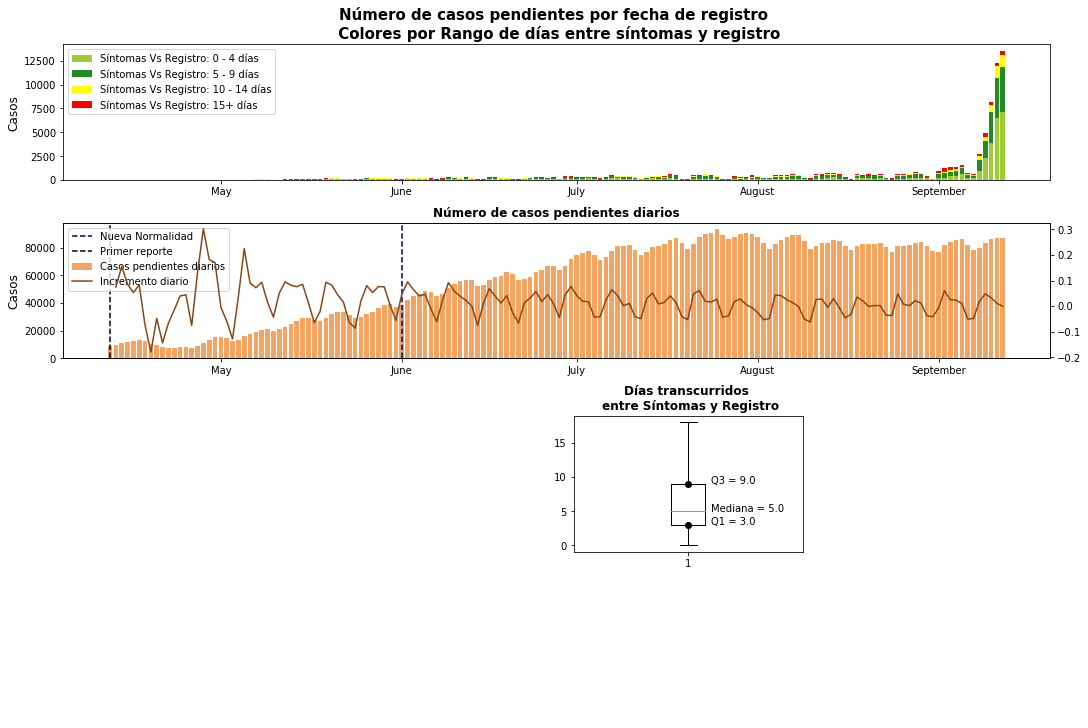

In [83]:
fig = plt.figure(constrained_layout=True,figsize=[15,10])

gs = GridSpec(4, 4, figure=fig)


#CASOS POSITIVOS POR FECHA DE REGISTRO, COLORES POR RANGO DE DÍAS ENTRE SÍNTOMAS Y REGISTRO
y1=pendiente_R1["0 - 4"]
y2=pendiente_R1["5 - 9"]
y3=pendiente_R1["10 - 14"]
y4=pendiente_R1["15+"]

aux_y1y2=np.add(pendiente_R1["0 - 4"],pendiente_R1["5 - 9"]).tolist()
aux_y1y2y3=np.add(aux_y1y2,pendiente_R1["10 - 14"]).tolist()

x1=pendiente_R1["R1_FECHA"]
colors=["yellowgreen","forestgreen","yellow","red"]

ax1 = fig.add_subplot(gs[0, 0:])
ax1.bar(x1,y1,color="yellowgreen",label="Síntomas Vs Registro: 0 - 4 días")
ax1.bar(x1,y2,color="forestgreen",bottom=y1,label="Síntomas Vs Registro: 5 - 9 días")
ax1.bar(x1,y3,color="yellow",bottom=aux_y1y2,label="Síntomas Vs Registro: 10 - 14 días")
ax1.bar(x1,y4,color="red",bottom=aux_y1y2y3,label="Síntomas Vs Registro: 15+ días")

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_ylabel("Casos", fontsize=12)
ax1.tick_params(labelsize=10)

#ax1.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
#ax1.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
#ax1.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax1.set_title("Número de casos pendientes por fecha de registro \n Colores por Rango de días entre síntomas y registro", fontsize=15, weight="bold")

ax1.legend()

#TIEMPO TRANSCURRIDO ENTRE SÍNTOMAS Y REGISTRO PARA CASOS CON RESULTADO NEGATIVO
ax3 = fig.add_subplot(gs[2, 2])
dias1=pendiente_R1_box["T1"].dropna()

data=([dias1])

ax3.boxplot(data,0,"")

q1 = pendiente_R1_box["T1"].quantile(0.25)
q2 = pendiente_R1_box["T1"].quantile(0.5)
q3 = pendiente_R1_box["T1"].quantile(0.75)
ax3.scatter(1, q1, c='k', label='Q1')
ax3.text(1.1, q1, "Q1 = {0}".format(q1))

ax3.text(1.1, q2, "Mediana = {0}".format(q2))
ax3.scatter(1, q3, c='k', label='Q3')
ax3.text(1.1, q3, "Q3 = {0}".format(q3))

ax3.set_title("Días transcurridos \n entre Síntomas y Registro", fontsize=12, weight="bold")

#PENDIENTES DIARIOS
y9=pendientes_diarios["PENDIENTES_DIARIOS"]
y10=pendientes_diarios["PENDIENTES_DELTA"]

x2=pendientes_diarios["FECHA_ACTUALIZACION"]

ax5 = fig.add_subplot(gs[1, 0:])
ax5.bar(x2,y9,color="sandybrown",label="Casos pendientes diarios")

ax6=ax5.twinx()
ax6.plot(x2,y10,color="saddlebrown",label="Incremento diario")

ax5.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax5.xaxis.set_major_locator(mdates.MonthLocator())
ax5.set_ylabel("Casos", fontsize=12)
ax5.tick_params(labelsize=10)

#ax5.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax5.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
ax5.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax5.set_title("Número de casos pendientes diarios", fontsize=12, weight="bold")

h1, l1 = ax5.get_legend_handles_labels()
h2, l2 = ax6.get_legend_handles_labels()
ax5.legend(h1+h2, l1+l2, loc="upper left")

plt.savefig("Images/Pendientes.png")

plt.show()

### Evolución de tiempos

#### Tiempo transcurrido entre síntomas y registro

In [84]:
R1_diario=Rt.loc[:,["T1_RANGO","R1_FECHA","ID_REGISTRO"]]
R1_diario=R1_diario.groupby(["R1_FECHA","T1_RANGO"],as_index=False).count()
R1_diario=R1_diario.dropna()
R1_diario=R1_diario.pivot(index="R1_FECHA",columns="T1_RANGO",values="ID_REGISTRO").rename_axis(None, axis=1)

R1_diario=R1_diario.rename(columns=str).reset_index()
#R1_diario=R1_diario.merge(aux_pendientes,on="R1_FECHA").fillna(0)
R1_diario["TOTAL"]=R1_diario["0 - 4"]+R1_diario["5 - 9"]+R1_diario["10 - 14"]+R1_diario["15+"]
R1_diario["%0 - 4"]=R1_diario["0 - 4"]/R1_diario["TOTAL"]*100
R1_diario["%5 - 9"]=R1_diario["5 - 9"]/R1_diario["TOTAL"]*100
R1_diario["%10 - 14"]=R1_diario["10 - 14"]/R1_diario["TOTAL"]*100
R1_diario["%15+"]=R1_diario["15+"]/R1_diario["TOTAL"]*100

R1_diario.tail()

,R1_FECHA,0 - 4,5 - 9,10 - 14,15+,TOTAL,%0 - 4,%5 - 9,%10 - 14,%15+
149,2020-09-08,7211,6066,1344,776,15397,46.833799,39.397285,8.728973,5.039943
150,2020-09-09,7774,6629,1246,863,16512,47.080911,40.146560,7.546027,5.226502
151,2020-09-10,7597,6307,1175,742,15821,48.018456,39.864737,7.426838,4.689969
152,2020-09-11,8100,5721,1663,625,16109,50.282451,35.514309,10.323422,3.879819
153,2020-09-12,7403,5149,1329,579,14460,51.196404,35.608575,9.190871,4.004149


In [85]:
R2_diario=Rt.loc[:,["T2_RANGO","R1_FECHA","ID_REGISTRO"]]
R2_diario=R2_diario.groupby(["R1_FECHA","T2_RANGO"],as_index=False).count()
R2_diario=R2_diario.dropna()
R2_diario=R2_diario.pivot(index="R1_FECHA",columns="T2_RANGO",values="ID_REGISTRO").rename_axis(None, axis=1)

aux_pendientes=pendiente_R1.loc[:,["R1_FECHA","TOTAL_PENDIENTES"]]

R2_diario=R2_diario.rename(columns=str).reset_index()
R2_diario=R2_diario.merge(aux_pendientes,on="R1_FECHA").fillna(0)
R2_diario["TOTAL"]=R2_diario["0 - 3"]+R2_diario["4 - 7"]+R2_diario["8 - 14"]+R2_diario["15+"]+R2_diario["TOTAL_PENDIENTES"]
R2_diario["%0 - 3"]=R2_diario["0 - 3"]/R2_diario["TOTAL"]*100
R2_diario["%4 - 7"]=R2_diario["4 - 7"]/R2_diario["TOTAL"]*100
R2_diario["%8 - 14"]=R2_diario["8 - 14"]/R2_diario["TOTAL"]*100
R2_diario["%15+"]=R2_diario["15+"]/R2_diario["TOTAL"]*100
R2_diario["%PENDIENTES"]=R2_diario["TOTAL_PENDIENTES"]/R2_diario["TOTAL"]*100

R2_diario.tail()

,R1_FECHA,0 - 3,4 - 7,8 - 14,15+,TOTAL_PENDIENTES,TOTAL,%0 - 3,%4 - 7,%8 - 14,%15+,%PENDIENTES
138,2020-09-08,11046.0,1709.0,0.0,0.0,2743.0,15498.0,71.273713,11.027229,0.0,0.0,17.699058
139,2020-09-09,11661.0,0.0,0.0,0.0,4893.0,16554.0,70.442189,0.000000,0.0,0.0,29.557811
140,2020-09-10,7623.0,0.0,0.0,0.0,8207.0,15830.0,48.155401,0.000000,0.0,0.0,51.844599
141,2020-09-11,3870.0,0.0,0.0,0.0,12262.0,16132.0,23.989586,0.000000,0.0,0.0,76.010414
142,2020-09-12,929.0,0.0,0.0,0.0,13531.0,14460.0,6.424620,0.000000,0.0,0.0,93.575380


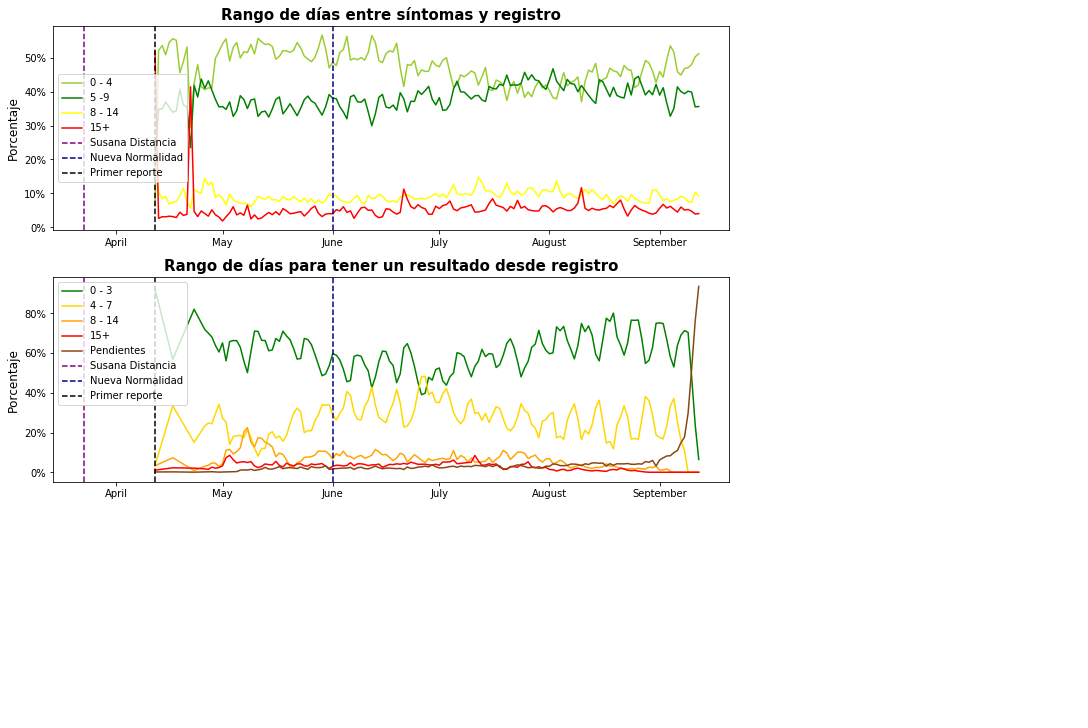

In [86]:
fig = plt.figure(constrained_layout=True,figsize=[15,10])

gs = GridSpec(3, 3, figure=fig)

#% FECHA DE PENDIENTES POR FECHA DE REGISTRO
y1=R2_diario["%0 - 3"]
y2=R2_diario["%4 - 7"]
y3=R2_diario["%8 - 14"]
y4=R2_diario["%15+"]
y5=R2_diario["%PENDIENTES"]

x1=R2_diario["R1_FECHA"]
ax1 = fig.add_subplot(gs[1, 0:2])
ax1.plot(x1,y1,label="0 - 3",color="green")
ax1.plot(x1,y2,label="4 - 7",color="gold")
ax1.plot(x1,y3,label="8 - 14",color="orange")
ax1.plot(x1,y4,label="15+",color="red")
ax1.plot(x1,y5,label="Pendientes",color="saddlebrown")

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())

ax1.set_ylabel("Porcentaje", fontsize=12)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))

ax1.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax1.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
ax1.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax1.set_title("Rango de días para tener un resultado desde registro", fontsize=15, weight="bold")
ax1.legend()

#% FECHA DE PENDIENTES POR FECHA DE REGISTRO
y6=R1_diario["%0 - 4"]
y7=R1_diario["%5 - 9"]
y8=R1_diario["%10 - 14"]
y9=R1_diario["%15+"]

x2=R1_diario["R1_FECHA"]
ax2 = fig.add_subplot(gs[0, 0:2])
ax2.plot(x2,y6,label="0 - 4",color="yellowgreen")
ax2.plot(x2,y7,label="5 -9",color="green")
ax2.plot(x2,y8,label="8 - 14",color="yellow")
ax2.plot(x2,y9,label="15+",color="red")

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax2.xaxis.set_major_locator(mdates.MonthLocator())

ax2.set_ylabel("Porcentaje", fontsize=12)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))

ax2.tick_params(labelsize=10)

ax2.axvline(x=susana_distancia,color="purple",label="Susana Distancia",linestyle="--")
ax2.axvline(x=nueva_normalidad,color="navy",label="Nueva Normalidad",linestyle="--")
ax2.axvline(x=fecha_primer_reporte,color="black",label="Primer reporte",linestyle="--")

ax2.set_title("Rango de días entre síntomas y registro", fontsize=15, weight="bold")
ax2.legend()

plt.savefig("Images/Tiempo transcurrido.png")

## DEFUNCIONES 

In [87]:
defunciones=Rt.loc[:,["ID_REGISTRO","FECHA_DEF","FECHA_SINTOMAS","RX_RESULTADO",
                                                  "R1_FECHA","R2_FECHA","R3_FECHA",
                                                  "T1","T2","T3","T4","T5",
                                                  "T1_RANGO","T2_RANGO","T3_RANGO","T4_RANGO","T5_RANGO"]]
defunciones=defunciones.dropna(subset=["FECHA_DEF"])
defunciones.head()

,ID_REGISTRO,FECHA_DEF,FECHA_SINTOMAS,RX_RESULTADO,R1_FECHA,R2_FECHA,R3_FECHA,T1,T2,T3,T4,T5,T1_RANGO,T2_RANGO,T3_RANGO,T4_RANGO,T5_RANGO
1,0bafd8,2020-05-09,2020-04-28,Positivo SARS-CoV-2,2020-04-29,2020-05-01,2020-06-21,1,2.0,43.0,10.0,11.0,0 - 4,0 - 3,+3 semanas,2 semana,2 semanas
6,1a73c1,2020-05-25,2020-05-21,Positivo SARS-CoV-2,2020-05-25,2020-05-30,2020-05-30,4,5.0,5.0,0.0,4.0,0 - 4,4 - 7,1 semana,Def antes de registro,1 semana
8,12944a,2020-04-28,2020-04-13,Positivo SARS-CoV-2,2020-04-17,2020-04-22,2020-04-29,4,5.0,1.0,11.0,15.0,0 - 4,4 - 7,1 semana,2 semana,3 semanas
9,022691,2020-05-01,2020-04-04,Positivo SARS-CoV-2,2020-04-12,2020-04-12,2020-05-07,8,0.0,6.0,19.0,27.0,5 - 9,0 - 3,1 semana,3 semanas,1 mes
14,1c1c5a,2020-05-08,2020-05-02,Positivo SARS-CoV-2,2020-05-08,2020-05-10,2020-05-13,6,2.0,5.0,0.0,6.0,5 - 9,0 - 3,1 semana,Def antes de registro,1 semana


In [88]:
defunciones_covid=defunciones.loc[defunciones["RX_RESULTADO"]=="Positivo SARS-CoV-2"]
defunciones_nocovid=defunciones.loc[defunciones["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
defunciones_pendientes=defunciones.loc[defunciones["RX_RESULTADO"]=="Resultado pendiente"]

1. Defunciones por fecha de registro del caso

In [89]:
def_covid_R1=defunciones_covid.loc[:,["R1_FECHA","ID_REGISTRO"]]
def_covid_R1=def_covid_R1.groupby(["R1_FECHA"],as_index=False).count()
def_covid_R1=def_covid_R1.rename(columns={"ID_REGISTRO":"DEFUNCIONES_R1"})

#Descartar primer reporte
def_covid_R1=def_covid_R1.loc[def_covid_R1["R1_FECHA"]!=fecha_primer_reporte]

def_covid_R1.head(10)

,R1_FECHA,DEFUNCIONES_R1
1,2020-04-13,125
2,2020-04-14,147
3,2020-04-15,149
4,2020-04-16,130
5,2020-04-17,212
6,2020-04-18,81
7,2020-04-19,63
8,2020-04-20,129
9,2020-04-21,155
10,2020-04-22,166


In [90]:
#Mortalidad por fecha de registro caso
aux_mortalidad_R1=covid_R1.loc[:,["R1_FECHA","TOTAL_R1"]]
aux_mortalidad_R1=aux_mortalidad_R1.rename(columns={"TOTAL_R1":"CASOS_COVID_R1"})

mortalidad_R1=def_covid_R1.merge(aux_mortalidad_R1,on="R1_FECHA")

mortalidad_R1["MORTALIDAD_R1"]=mortalidad_R1["DEFUNCIONES_R1"]/mortalidad_R1["CASOS_COVID_R1"]*100

mortalidad_R1.head()

,R1_FECHA,DEFUNCIONES_R1,CASOS_COVID_R1,MORTALIDAD_R1
0,2020-04-13,125,531,23.540490
1,2020-04-14,147,739,19.891746
2,2020-04-15,149,798,18.671679
3,2020-04-16,130,738,17.615176
4,2020-04-17,212,1057,20.056764


In [91]:
mortalidad=mortalidad_R1["DEFUNCIONES_R1"].sum()/mortalidad_R1["CASOS_COVID_R1"].sum()

In [92]:
def_covid_T1=defunciones_covid.loc[:,["R1_FECHA","ID_REGISTRO","T1_RANGO"]]
def_covid_T1=def_covid_T1.groupby(["R1_FECHA","T1_RANGO"],as_index=False).count()
def_covid_T1=def_covid_T1.rename(columns={"ID_REGISTRO":"DEFUNCIONES_T1"})

#Descartar primer reporte
def_covid_T1=def_covid_T1.loc[def_covid_T1["R1_FECHA"]!=fecha_primer_reporte]

def_covid_T1=def_covid_T1.pivot(index="R1_FECHA",columns="T1_RANGO",values="DEFUNCIONES_T1").rename_axis(None, axis=1)

def_covid_T1=def_covid_T1.rename(columns=str).reset_index()

def_covid_T1=def_covid_T1.merge(covid_R1,on=["R1_FECHA"],suffixes=["_DEF","_TOTAL"])
def_covid_T1=def_covid_T1.drop(columns=["TOTAL_R1","SUMA_7D_R1","MEDIA_7D_R1","DELTA_7D_R1"])

def_covid_T1["%MORT_0 - 3"]=def_covid_T1["0 - 4_DEF"]/def_covid_T1["0 - 4_TOTAL"]*100
def_covid_T1["%MORT_4 - 7"]=def_covid_T1["5 - 9_DEF"]/def_covid_T1["5 - 9_TOTAL"]*100
def_covid_T1["%MORT_8 - 14"]=def_covid_T1["10 - 14_DEF"]/def_covid_T1["10 - 14_TOTAL"]*100
def_covid_T1["%MORT_15+"]=def_covid_T1["15+_DEF"]/def_covid_T1["15+_TOTAL"]*100

prom_mort_T1_0_3=def_covid_T1["0 - 4_DEF"].sum()/def_covid_T1["0 - 4_TOTAL"].sum()
prom_mort_T1_4_7=def_covid_T1["5 - 9_DEF"].sum()/def_covid_T1["5 - 9_TOTAL"].sum()
prom_mort_T1_8_14=def_covid_T1["10 - 14_DEF"].sum()/def_covid_T1["10 - 14_TOTAL"].sum()
prom_mort_T1_15=def_covid_T1["15+_DEF"].sum()/def_covid_T1["15+_TOTAL"].sum()

def_covid_T1.head(10)

,R1_FECHA,0 - 4_DEF,5 - 9_DEF,10 - 14_DEF,15+_DEF,0 - 4_TOTAL,5 - 9_TOTAL,10 - 14_TOTAL,15+_TOTAL,%MORT_0 - 3,%MORT_4 - 7,%MORT_8 - 14,%MORT_15+
0,2020-04-13,30.0,68.0,23.0,4.0,210,226,81,14,14.285714,30.088496,28.395062,28.571429
1,2020-04-14,49.0,65.0,17.0,15.0,309,317,80,33,15.857605,20.504732,21.250000,45.454545
2,2020-04-15,41.0,79.0,24.0,4.0,313,346,114,25,13.099042,22.832370,21.052632,16.000000
3,2020-04-16,44.0,63.0,17.0,6.0,289,350,74,25,15.224913,18.000000,22.972973,24.000000
4,2020-04-17,72.0,115.0,16.0,9.0,458,450,106,43,15.720524,25.555556,15.094340,20.930233
5,2020-04-18,30.0,42.0,4.0,3.0,140,170,40,12,21.428571,24.705882,10.000000,25.000000
6,2020-04-19,19.0,32.0,5.0,7.0,89,124,31,14,21.348315,25.806452,16.129032,50.000000
7,2020-04-20,46.0,51.0,24.0,8.0,195,233,94,23,23.589744,21.888412,25.531915,34.782609
8,2020-04-21,46.0,77.0,19.0,12.0,326,334,86,36,14.110429,23.053892,22.093023,33.333333
9,2020-04-22,52.0,78.0,25.0,11.0,306,438,119,66,16.993464,17.808219,21.008403,16.666667


2. Defunciones por fecha de síntomas

In [93]:
def_covid_sintomas=defunciones_covid.loc[:,["FECHA_SINTOMAS","ID_REGISTRO"]]
def_covid_sintomas=def_covid_sintomas.groupby(["FECHA_SINTOMAS"],as_index=False).count()
def_covid_sintomas=def_covid_sintomas.rename(columns={"ID_REGISTRO":"DEFUNCIONES_SINTOMAS"})

In [94]:
def_covid_sintomas.head()

,FECHA_SINTOMAS,DEFUNCIONES_SINTOMAS
0,2020-02-26,1
1,2020-02-27,1
2,2020-03-01,1
3,2020-03-02,1
4,2020-03-03,2


3. Defunciones por fecha de defunción

In [95]:
def_covid_fecha=defunciones_covid.loc[:,["FECHA_DEF","ID_REGISTRO"]]
def_covid_fecha=def_covid_fecha.groupby(["FECHA_DEF"],as_index=False).count()

In [96]:
#Cuándo fue registrada la fecha de defunción
covid_def_fecha=covid.loc[:,["FECHA_DEF","ID_REGISTRO","T3_RANGO"]]
covid_def_fecha=covid_def_fecha.groupby(["FECHA_DEF","T3_RANGO"],as_index=False).count()
covid_def_fecha=covid_def_fecha.rename(columns={"ID_REGISTRO":"NUM_COVID_DEF_FECHA"})

covid_def_fecha=covid_def_fecha.pivot(index='FECHA_DEF', columns='T3_RANGO', values='NUM_COVID_DEF_FECHA').rename_axis(None, axis=1)
covid_def_fecha=covid_def_fecha.rename(columns=str).reset_index()
covid_def_fecha=covid_def_fecha.fillna(0)

covid_def_fecha["TOTAL"]=covid_def_fecha["1 semana"]+covid_def_fecha["2 semana"]+covid_def_fecha["3 semanas"]+covid_def_fecha["+3 semanas"]

covid_def_fecha["%1 sem"]=covid_def_fecha["1 semana"]/covid_def_fecha["TOTAL"]*100
covid_def_fecha["%2 sem"]=covid_def_fecha["2 semana"]/covid_def_fecha["TOTAL"]*100
covid_def_fecha["%3 sem"]=covid_def_fecha["3 semanas"]/covid_def_fecha["TOTAL"]*100
covid_def_fecha["%+3 sem"]=covid_def_fecha["+3 semanas"]/covid_def_fecha["TOTAL"]*100

covid_def_fecha.head(10)

,FECHA_DEF,1 semana,2 semana,3 semanas,+3 semanas,TOTAL,%1 sem,%2 sem,%3 sem,%+3 sem
0,2020-03-18,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.000000,100.000000
1,2020-03-20,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,100.000000
2,2020-03-22,0.0,0.0,1.0,0.0,1.0,0.0,0.0,100.000000,0.000000
3,2020-03-23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,100.000000,0.000000
4,2020-03-24,0.0,0.0,2.0,0.0,2.0,0.0,0.0,100.000000,0.000000
5,2020-03-25,0.0,0.0,2.0,0.0,2.0,0.0,0.0,100.000000,0.000000
6,2020-03-26,0.0,0.0,8.0,0.0,8.0,0.0,0.0,100.000000,0.000000
7,2020-03-27,0.0,0.0,6.0,1.0,7.0,0.0,0.0,85.714286,14.285714
8,2020-03-28,0.0,0.0,13.0,1.0,14.0,0.0,0.0,92.857143,7.142857
9,2020-03-29,0.0,7.0,1.0,0.0,8.0,0.0,87.5,12.500000,0.000000


4. Defunciones por fecha de notificación de defunción

In [97]:
def_covid_R3=defunciones_covid.loc[:,["R3_FECHA","ID_REGISTRO"]]
def_covid_R3=def_covid_R3.groupby(["R3_FECHA"],as_index=False).count()

In [98]:
#Cuándo fue registrada la fecha de defunción
covid_R3=covid.loc[:,["R3_FECHA","ID_REGISTRO","T3_RANGO"]]
covid_R3=covid_R3.groupby(["R3_FECHA","T3_RANGO"],as_index=False).count()
covid_R3=covid_R3.rename(columns={"ID_REGISTRO":"NUM_COVID_R3"})

#Se descarta primer reporte, dado que los casos con resultado negativo son el acumulado hasta esta fecha
#Considera casos reportados ya con resultado Negativo como casos pendientes que posteriormente tendrán resultado negativo
covid_R1=covid_R1.loc[covid_R1["R1_FECHA"]!=fecha_primer_reporte]

covid_R3=covid_R3.pivot(index='R3_FECHA', columns='T3_RANGO', values='NUM_COVID_R3').rename_axis(None, axis=1)
covid_R3=covid_R3.rename(columns=str).reset_index()
covid_R3=covid_R3.fillna(0)

covid_R3["TOTAL_R3"]=covid_R3["1 semana"]+covid_R3["2 semana"]+covid_R3["3 semanas"]+covid_R3["+3 semanas"]

covid_R3.head(10)

,R3_FECHA,1 semana,2 semana,3 semanas,+3 semanas,TOTAL_R3
0,2020-04-12,160.0,113.0,32.0,3.0,308.0
1,2020-04-13,29.0,6.0,1.0,0.0,36.0
2,2020-04-14,70.0,11.0,1.0,0.0,82.0
3,2020-04-15,33.0,5.0,0.0,0.0,38.0
4,2020-04-16,25.0,5.0,1.0,0.0,31.0
5,2020-04-17,69.0,14.0,1.0,0.0,84.0
6,2020-04-18,63.0,24.0,3.0,0.0,90.0
7,2020-04-19,25.0,3.0,1.0,0.0,29.0
8,2020-04-20,30.0,2.0,0.0,0.0,32.0
9,2020-04-21,118.0,17.0,6.0,0.0,141.0


In [99]:
def_covid_T3=defunciones_covid.loc[:,["R3_FECHA","ID_REGISTRO","T3_RANGO"]]
def_covid_T3=def_covid_T3.groupby(["R3_FECHA","T3_RANGO"],as_index=False).count()
def_covid_T3=def_covid_T3.rename(columns={"ID_REGISTRO":"DEFUNCIONES_T3"})

#Descartar primer reporte
def_covid_T3=def_covid_T3.loc[def_covid_T3["R3_FECHA"]!=fecha_primer_reporte]

def_covid_T3=def_covid_T3.pivot(index="R3_FECHA",columns="T3_RANGO",values="DEFUNCIONES_T3").rename_axis(None, axis=1)

def_covid_T3=def_covid_T3.rename(columns=str).reset_index()
def_covid_T3=def_covid_T3.fillna(0)

def_covid_T3["TOTAL"]=def_covid_T3["1 semana"]+def_covid_T3["2 semana"]+def_covid_T3["3 semanas"]+def_covid_T3["+3 semanas"]

def_covid_T3["%1 sem"]=def_covid_T3["1 semana"]/def_covid_T3["TOTAL"]*100
def_covid_T3["%2 sem"]=def_covid_T3["2 semana"]/def_covid_T3["TOTAL"]*100
def_covid_T3["%3 sem"]=def_covid_T3["3 semanas"]/def_covid_T3["TOTAL"]*100
def_covid_T3["%+3 sem"]=def_covid_T3["+3 semanas"]/def_covid_T3["TOTAL"]*100
#def_covid_T1["%MORT_4 - 7"]=def_covid_T1["5 - 9_DEF"]/def_covid_T1["5 - 9_TOTAL"]*100
#def_covid_T1["%MORT_8 - 14"]=def_covid_T1["10 - 14_DEF"]/def_covid_T1["10 - 14_TOTAL"]*100
#def_covid_T1["%MORT_15+"]=def_covid_T1["15+_DEF"]/def_covid_T1["15+_TOTAL"]*100

#prom_mort_T1_0_3=def_covid_T1["0 - 4_DEF"].sum()/def_covid_T1["0 - 4_TOTAL"].sum()
#prom_mort_T1_4_7=def_covid_T1["5 - 9_DEF"].sum()/def_covid_T1["5 - 9_TOTAL"].sum()
#prom_mort_T1_8_14=def_covid_T1["10 - 14_DEF"].sum()/def_covid_T1["10 - 14_TOTAL"].sum()
#prom_mort_T1_15=def_covid_T1["15+_DEF"].sum()/def_covid_T1["15+_TOTAL"].sum()

def_covid_T3.head(10)

,R3_FECHA,1 semana,2 semana,3 semanas,+3 semanas,TOTAL,%1 sem,%2 sem,%3 sem,%+3 sem
0,2020-04-13,29.0,6.0,1.0,0.0,36.0,80.555556,16.666667,2.777778,0.0
1,2020-04-14,70.0,11.0,1.0,0.0,82.0,85.365854,13.414634,1.219512,0.0
2,2020-04-15,33.0,5.0,0.0,0.0,38.0,86.842105,13.157895,0.000000,0.0
3,2020-04-16,25.0,5.0,1.0,0.0,31.0,80.645161,16.129032,3.225806,0.0
4,2020-04-17,69.0,14.0,1.0,0.0,84.0,82.142857,16.666667,1.190476,0.0
5,2020-04-18,63.0,24.0,3.0,0.0,90.0,70.000000,26.666667,3.333333,0.0
6,2020-04-19,25.0,3.0,1.0,0.0,29.0,86.206897,10.344828,3.448276,0.0
7,2020-04-20,30.0,2.0,0.0,0.0,32.0,93.750000,6.250000,0.000000,0.0
8,2020-04-21,118.0,17.0,6.0,0.0,141.0,83.687943,12.056738,4.255319,0.0
9,2020-04-22,85.0,14.0,1.0,0.0,100.0,85.000000,14.000000,1.000000,0.0


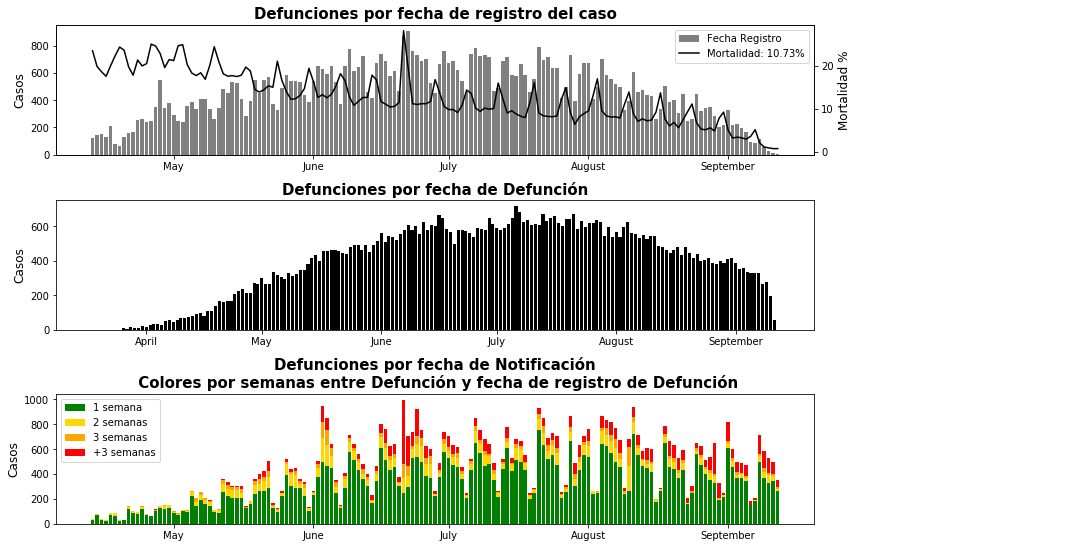

In [100]:
fig = plt.figure(constrained_layout=True,figsize=[15,7.5])

gs = GridSpec(3, 3, figure=fig)


#DEFUNCIONES POR FECHA DE REGISTRO DEL CASO
y1=def_covid_R1["DEFUNCIONES_R1"]

x1=def_covid_R1["R1_FECHA"]

ax1 = fig.add_subplot(gs[0, 0:2])
ax1.bar(x1,y1,color="gray",label="Fecha Registro")

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_ylabel("Casos", fontsize=12)
ax1.tick_params(labelsize=10)

y2= mortalidad_R1["MORTALIDAD_R1"]
x2= mortalidad_R1["R1_FECHA"]

ax2=ax1.twinx()
ax2.plot(x2,y2,color="black",label="Mortalidad: "+ str("{:.2%}".format(mortalidad)))

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.set_ylabel("Mortalidad %", fontsize=12)
ax2.tick_params(labelsize=10)

ax1.set_title("Defunciones por fecha de registro del caso", fontsize=15, weight="bold")

#ax1.axvline(x=primer_reporte,color="green",label="Primer reporte",linestyle="--")
#ax1.text(primer_reporte, 6000, '  Primer Reporte: ' + str(positivos_R1)+ " casos positivos reportados.")
#ax1.text(primer_reporte, 5500," De los casos pendientes en el primer reporte,") 
#ax1.text(primer_reporte, 5000, str(positivos_R2-positivos_R1)+" casos resultaron positivos")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper right")

#DEFUNCIONES POR FECHA DE SÍNTOMAS
#y3=def_covid_sintomas["ID_REGISTRO"]

#x3=def_covid_sintomas["FECHA_SINTOMAS"]

#ax3 = fig.add_subplot(gs[1, 0:2])
#ax3.bar(x3,y3,color="black",label="Fecha Sintomas")

#ax3.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
#ax3.xaxis.set_major_locator(mdates.MonthLocator())
#ax3.set_ylabel("Casos", fontsize=12)
#ax3.tick_params(labelsize=10)

#ax3.set_title("Defunciones por fecha de Síntomas", fontsize=15, weight="bold")

#ax2.axvline(x=primer_reporte,color="green",label="Primer reporte",linestyle="--")
#ax2.text(primer_reporte, 6000, '  Primer Reporte: ' + str(positivos_R1)+ " casos positivos reportados.")
#ax2.text(primer_reporte, 5500," De los casos pendientes en el primer reporte,") 
#ax2.text(primer_reporte, 5000, str(positivos_R2-positivos_R1)+" casos resultaron positivos")

#ax3.legend()

#DEFUNCIONES POR FECHA DE DEFUNCIÓN
y4=def_covid_fecha["ID_REGISTRO"]

x4=def_covid_fecha["FECHA_DEF"]

ax4 = fig.add_subplot(gs[1, 0:2])
ax4.bar(x4,y4,color="black",label="Fecha Síntomas")

ax4.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax4.xaxis.set_major_locator(mdates.MonthLocator())
ax4.set_ylabel("Casos", fontsize=12)
ax4.tick_params(labelsize=10)

ax4.set_title("Defunciones por fecha de Defunción", fontsize=15, weight="bold")

#DEFUNCIONES POR FECHA DE NOTIFICACIÓN DE DEFUNCIÓN

y5=def_covid_T3["1 semana"]
y6=def_covid_T3["2 semana"]
y7=def_covid_T3["3 semanas"]
y8=def_covid_T3["+3 semanas"]

aux_y5y6=np.add(def_covid_T3["1 semana"],def_covid_T3["2 semana"]).tolist()
aux_y5y6y7=np.add(aux_y5y6,def_covid_T3["3 semanas"]).tolist()


x5=def_covid_T3["R3_FECHA"]

ax5 = fig.add_subplot(gs[2, 0:2])

ax5.bar(x5,y5,color="green",label="1 semana")
ax5.bar(x5,y6,color="gold",bottom=y5,label="2 semanas")
ax5.bar(x5,y7,color="orange",bottom=aux_y5y6,label="3 semanas")
ax5.bar(x5,y8,color="red",bottom=aux_y5y6y7,label="+3 semanas")

ax5.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax5.xaxis.set_major_locator(mdates.MonthLocator())
ax5.set_ylabel("Casos", fontsize=12)
ax5.tick_params(labelsize=10)

ax5.set_title("Defunciones por fecha de Notificación" +
              "\n Colores por semanas entre Defunción y fecha de registro de Defunción", fontsize=15, weight="bold")

ax5.legend()

plt.savefig("Images/Defunciones.png")

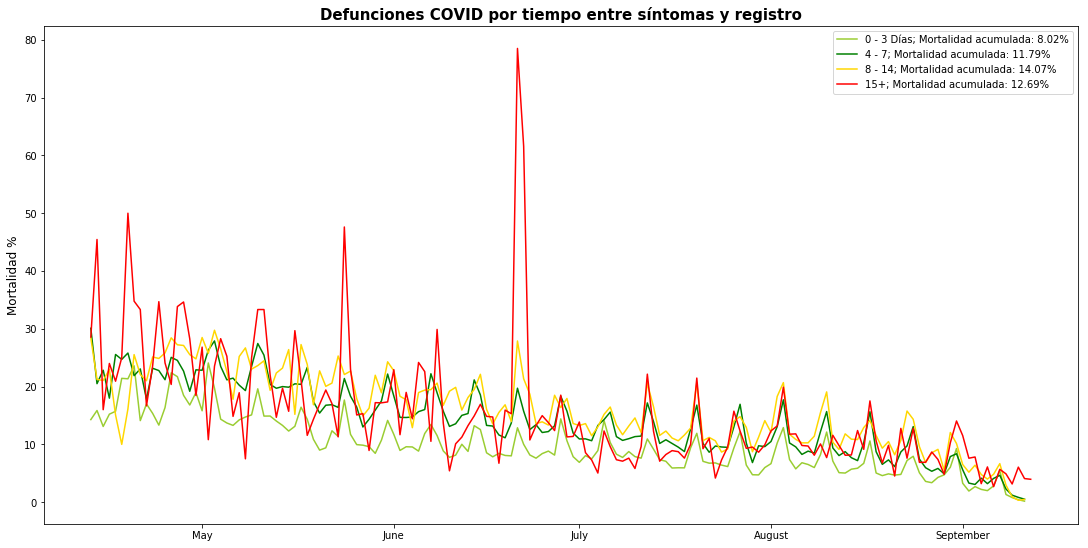

In [101]:
fig = plt.figure(constrained_layout=True,figsize=[15,7.5])

gs = GridSpec(1, 1, figure=fig)


#DEFUNCIONES POR FECHA DE REGISTRO DEL CASO
y1=def_covid_T1["%MORT_0 - 3"]
y2=def_covid_T1["%MORT_4 - 7"]
y3=def_covid_T1["%MORT_8 - 14"]
y4=def_covid_T1["%MORT_15+"]

x1=def_covid_R1["R1_FECHA"]

ax1 = fig.add_subplot(gs[0, 0:2])

ax1.plot(x1,y1,color="yellowgreen",label="0 - 3 Días; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_0_3)))
ax1.plot(x1,y2,color="green",label="4 - 7; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_4_7)))
ax1.plot(x1,y3,color="gold",label="8 - 14; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_8_14)))
ax1.plot(x1,y4,color="red",label="15+; Mortalidad acumulada: "+str("{:.2%}".format(prom_mort_T1_15)))

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_ylabel("Mortalidad %", fontsize=12)
ax1.tick_params(labelsize=10)

ax1.set_title("Defunciones COVID por tiempo entre síntomas y registro", fontsize=15, weight="bold")

#ax1.axvline(x=primer_reporte,color="green",label="Primer reporte",linestyle="--")
#ax1.text(primer_reporte, 6000, '  Primer Reporte: ' + str(positivos_R1)+ " casos positivos reportados.")
#ax1.text(primer_reporte, 5500," De los casos pendientes en el primer reporte,") 
#ax1.text(primer_reporte, 5000, str(positivos_R2-positivos_R1)+" casos resultaron positivos")

ax1.legend()

plt.savefig("Images/Mortalidad_Sintomas_Examen.png")

In [102]:
def_covid_T3.head()

,R3_FECHA,1 semana,2 semana,3 semanas,+3 semanas,TOTAL,%1 sem,%2 sem,%3 sem,%+3 sem
0,2020-04-13,29.0,6.0,1.0,0.0,36.0,80.555556,16.666667,2.777778,0.0
1,2020-04-14,70.0,11.0,1.0,0.0,82.0,85.365854,13.414634,1.219512,0.0
2,2020-04-15,33.0,5.0,0.0,0.0,38.0,86.842105,13.157895,0.000000,0.0
3,2020-04-16,25.0,5.0,1.0,0.0,31.0,80.645161,16.129032,3.225806,0.0
4,2020-04-17,69.0,14.0,1.0,0.0,84.0,82.142857,16.666667,1.190476,0.0


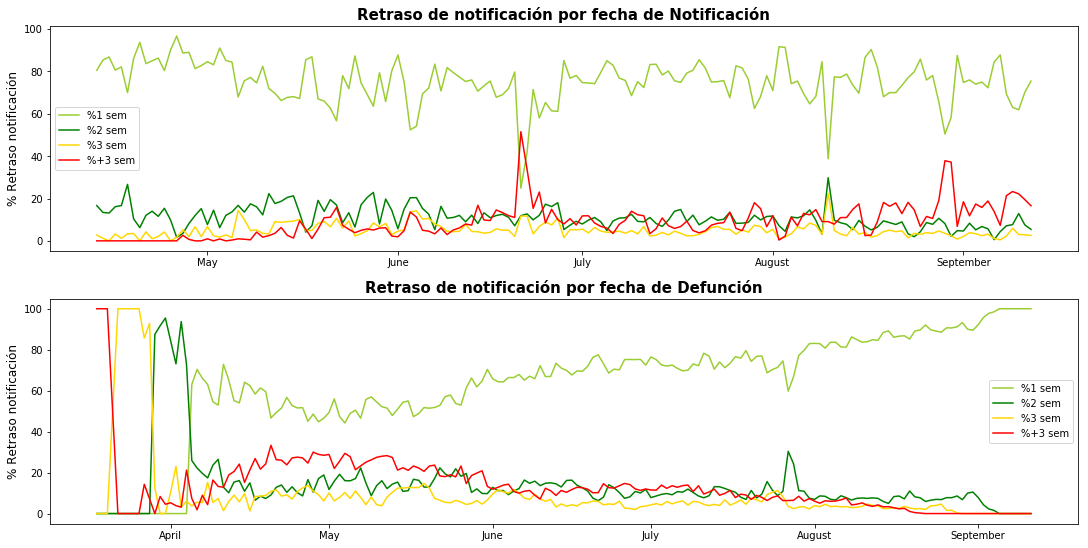

In [103]:
fig = plt.figure(constrained_layout=True,figsize=[15,7.5])

gs = GridSpec(2, 1, figure=fig)


#DEFUNCIONES POR FECHA DE REGISTRO DEL CASO
y1=def_covid_T3["%1 sem"]
y2=def_covid_T3["%2 sem"]
y3=def_covid_T3["%3 sem"]
y4=def_covid_T3["%+3 sem"]

x1=def_covid_T3["R3_FECHA"]

ax1 = fig.add_subplot(gs[0, 0:2])

ax1.plot(x1,y1,color="yellowgreen")#,label="0 - 3 Días; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_0_3)))
ax1.plot(x1,y2,color="green")#,label="4 - 7; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_4_7)))
ax1.plot(x1,y3,color="gold")#,label="8 - 14; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_8_14)))
ax1.plot(x1,y4,color="red")#,label="15+; Mortalidad acumulada: "+str("{:.2%}".format(prom_mort_T1_15)))

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_ylabel("% Retraso notificación", fontsize=12)
ax1.tick_params(labelsize=10)

ax1.set_title("Retraso de notificación por fecha de Notificación", fontsize=15, weight="bold")

#ax1.axvline(x=primer_reporte,color="green",label="Primer reporte",linestyle="--")
#ax1.text(primer_reporte, 6000, '  Primer Reporte: ' + str(positivos_R1)+ " casos positivos reportados.")
#ax1.text(primer_reporte, 5500," De los casos pendientes en el primer reporte,") 
#ax1.text(primer_reporte, 5000, str(positivos_R2-positivos_R1)+" casos resultaron positivos")

ax1.legend()

#DEFUNCIONES POR FECHA DE DEFUNCIÓN
y5=covid_def_fecha["%1 sem"]
y6=covid_def_fecha["%2 sem"]
y7=covid_def_fecha["%3 sem"]
y8=covid_def_fecha["%+3 sem"]

x2=covid_def_fecha["FECHA_DEF"]

ax2 = fig.add_subplot(gs[1, 0:2])

ax2.plot(x2,y5,color="yellowgreen")#,label="0 - 3 Días; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_0_3)))
ax2.plot(x2,y6,color="green")#,label="4 - 7; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_4_7)))
ax2.plot(x2,y7,color="gold")#,label="8 - 14; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_8_14)))
ax2.plot(x2,y8,color="red")#,label="15+; Mortalidad acumulada: "+str("{:.2%}".format(prom_mort_T1_15)))

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.set_ylabel("% Retraso notificación", fontsize=12)
ax2.tick_params(labelsize=10)

ax2.set_title("Retraso de notificación por fecha de Defunción", fontsize=15, weight="bold")

#ax1.axvline(x=primer_reporte,color="green",label="Primer reporte",linestyle="--")
#ax1.text(primer_reporte, 6000, '  Primer Reporte: ' + str(positivos_R1)+ " casos positivos reportados.")
#ax1.text(primer_reporte, 5500," De los casos pendientes en el primer reporte,") 
#ax1.text(primer_reporte, 5000, str(positivos_R2-positivos_R1)+" casos resultaron positivos")

ax2.legend()

plt.savefig("Images/Retraso_notificación_defunción.png")

In [104]:
covid_def_fecha.head()

,FECHA_DEF,1 semana,2 semana,3 semanas,+3 semanas,TOTAL,%1 sem,%2 sem,%3 sem,%+3 sem
0,2020-03-18,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,100.0
1,2020-03-20,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,100.0
2,2020-03-22,0.0,0.0,1.0,0.0,1.0,0.0,0.0,100.0,0.0
3,2020-03-23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,100.0,0.0
4,2020-03-24,0.0,0.0,2.0,0.0,2.0,0.0,0.0,100.0,0.0


In [105]:
#Juntar tablas, calcular tiempos
#1. Tiempo síntomas Vs tiempo primer registro
#2. Tiempo síntomas Vs tiempo UCI
#3. Tiempo síntomas Vs tiempo intubado
#4. Tiempo UCI Vs tiempo intubado
#5. Tiempo síntomas Vs Fecha defunción
#6. Tiempo UCI Vs Fecha defunción
#7. Tiempo Intubado Vs Fecha defunción
#8. Tiempo Fecha_Reporte_Def Vs Fecha Defunción